# 分割前

device: cuda
[0] L_real_mix=0.1904 L_real_sem=97.8570 L_cf_s0=0.4949 L_cf_p0=0.4851 L_mono=0.0012 L_cos=0.1403 H_I=0.8321 L_env=0.0000 L_self=0.1126 L_rev=0.6797 mse_s=0.3788 mse_p=0.2617 mse=0.3203 rev_abs_mean=0.0908 rev_std=0.0779 self_mass=0.1426 Val_sem=99.3259
   [MON-TR] y_mean=0.6855 y_std=0.0031 y_min=0.6781 y_max=0.6902 corr=0.7262 m_real=0.6855 m_s0=0.6884 m_p0=0.6816 gap_s=-0.0029 gap_p=0.0040 ratio_s=1.0042 ratio_p=0.9942 env_sum=0.4322 I_sum=0.4256 self=0.1423 H_I=0.8311
   [MON-VA] y_mean=0.6856 y_std=0.0031 y_min=0.6782 y_max=0.6902 corr=0.7122 m_real=0.6856 m_s0=0.6884 m_p0=0.6817 gap_s=-0.0028 gap_p=0.0039 ratio_s=1.0041 ratio_p=0.9943 env_sum=0.4321 I_sum=0.4256 self=0.1423 H_I=0.8311
[200] L_real_mix=0.0235 L_real_sem=6.5013 L_cf_s0=0.0457 L_cf_p0=0.0000 L_mono=0.0000 L_cos=0.2509 H_I=0.8593 L_env=0.0000 L_self=0.1153 L_rev=0.0000 mse_s=2.2108 mse_p=1.9928 mse=2.1018 rev_abs_mean=1.0245 rev_std=0.0870 self_mass=0.1453 Val_sem=6.6095
   [MON-TR] y_mean=0.5406 y_std=0

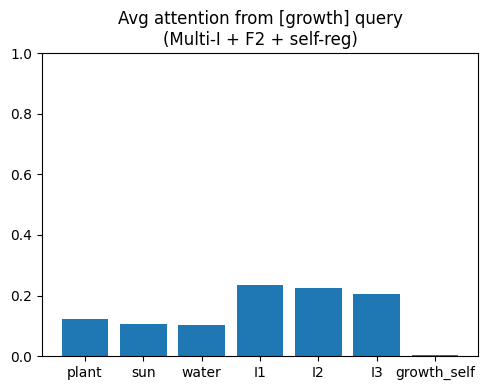

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- Collapse guards (minimal) ----
LAMBDA_SEM_MIN = 0.20   # semantic回帰の下限（αに依らず確保）
CF_HINGE_MARGIN = 1e-3  # 反事実 hinge のマージン
LOGSPACE_EPS = 1e-8     # log-space用

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1. データ生成（前回と同じ）
# -----------------------------
def generate_world_data(n):
    plant = torch.bernoulli(torch.full((n,), 0.7))
    sun   = torch.rand(n)
    water = torch.rand(n)

    base = 1.2*sun + 0.8*water
    base = torch.tanh(base * 2.0)
    noise = 0.05*torch.randn(n)
    growth = plant * (base + noise)
    growth = torch.clamp(growth, min=0.0)
    return plant, sun, water, growth

N = 5000
plant, sun, water, growth = generate_world_data(N)

perm = torch.randperm(N)
train_idx = perm[: int(0.8*N)]
val_idx   = perm[int(0.8*N):]

train_data = (
    plant[train_idx].to(device),
    sun[train_idx].to(device),
    water[train_idx].to(device),
    growth[train_idx].to(device),
)
val_data = (
    plant[val_idx].to(device),
    sun[val_idx].to(device),
    water[val_idx].to(device),
    growth[val_idx].to(device),
)

# -----------------------------
# 2. Multi-head Self-Attention
# -----------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None, need_weights=False):
        B, T, D = x.shape
        H, Dh = self.n_heads, self.d_head

        q = self.q_proj(x).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(x).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, Dh).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (Dh ** 0.5)

        if attn_mask is not None:
            if attn_mask.shape != scores.shape:
                raise ValueError(f"attn_mask shape {attn_mask.shape} must match scores {scores.shape}")
            scores = attn_mask.to(dtype=scores.dtype, device=scores.device).add_(scores)

        attn = torch.softmax(scores, dim=-1)           # (B,H,T,T)
        out = torch.matmul(attn, v)                    # (B,H,T,Dh)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)

        if need_weights:
            return out, attn
        return out, None

# -----------------------------
# 3. Multi-I 世界モデル (F2 用拡張)
#    トークン列: [plant, sun, water, I1, I2, I3, growth]
# -----------------------------
class MultiIWorldModel(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        self.d_model = d_model

        # 外界トークン
        self.embed_in = nn.Linear(1, d_model)

        # 3つの I を作る MLP
        self.I_mlp = nn.Sequential(
            nn.Linear(3, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3 * d_model),  # I1,I2,I3 をまとめて出す
        )

        # growth クエリトークン
        self.growth_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        self.attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

        # 意味ブランチ用 head（従来の growth token から）
        self.head_sem = nn.Linear(d_model, 1)
        # 統計ブランチ用 head（env 平均から）
        self.head_stat = nn.Linear(d_model, 1)
        # 逆向き head（growth token から env を推定）
        self.head_reverse = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3),
        )

    def forward(self, plant, sun, water,
                return_attn=False, return_both=False):
        B = plant.shape[0]

        p = self.embed_in(plant.view(B, 1, 1))
        s = self.embed_in(sun.view(B, 1, 1))
        w = self.embed_in(water.view(B, 1, 1))

        env = torch.stack([plant, sun, water], dim=-1)      # (B,3)
        I_all = self.I_mlp(env)                             # (B,3D)
        I_all = I_all.view(B, 3, self.d_model)              # (B,3,D)
        I1, I2, I3 = I_all[:, 0:1, :], I_all[:, 1:2, :], I_all[:, 2:3, :]

        g = self.growth_token.expand(B, -1, -1)             # (B,1,D)

        # [plant, sun, water, I1, I2, I3, growth]
        x = torch.cat([p, s, w, I1, I2, I3, g], dim=1)      # (B,7,D)

        # Attention mask (下三角 + I 限定参照):
        #   - env 同士は時間方向の下三角（未来禁止）
        #   - I1-3 は env(plant,sun,water) のみ参照可
        #   - growth は過去/現在のみ参照可（下三角）
        T = x.size(1)
        base = torch.zeros((T, T), device=x.device, dtype=x.dtype)
        upper = torch.triu(torch.ones((T, T), device=x.device), diagonal=1).bool()
        base = base.masked_fill(upper, float("-inf"))
        base[3:6, :] = float("-inf")
        base[3:6, 0:3] = 0.0

        attn_mask = base.unsqueeze(0).unsqueeze(0).expand(B, self.attn.n_heads, T, T).clone()

        x_out, attn = self.attn(x, attn_mask=attn_mask, need_weights=True)       # attn:(B,H,7,7)

        # semantic / meaning ブランチ
        growth_sem_rep  = x_out[:, 6, :]                    # growth token
        growth_sem_raw  = self.head_sem(growth_sem_rep).squeeze(-1)
        growth_sem_pred = F.softplus(growth_sem_raw) + 1e-6

        # statistical ブランチ
        env_reps  = x_out[:, 0:3, :]                        # plant,sun,water
        env_mean  = env_reps.mean(dim=1)                    # (B,D)
        growth_stat_raw  = self.head_stat(env_mean).squeeze(-1)
        growth_stat_pred = F.softplus(growth_stat_raw)

        if return_both:
            return growth_stat_pred, growth_sem_pred, attn, (I1, I2, I3)

        if return_attn:
            return growth_sem_pred, attn, (I1, I2, I3)

        # デフォルトは semantic 出力
        return growth_sem_pred

    def reverse_from_growth(self, batch_size, device=None):
        """
        growth トークンのみを残し、他トークンをゼロ埋めした入力から
        env (plant, sun, water) を逆推定するヘッド。
        """
        if device is None:
            device = self.growth_token.device

        g = self.growth_token.expand(batch_size, -1, -1).to(device=device)
        zeros_env = torch.zeros(batch_size, 6, self.d_model, device=device, dtype=g.dtype)
        x_rev = torch.cat([zeros_env, g], dim=1)

        x_rev_out, _ = self.attn(x_rev, need_weights=False)
        growth_rev_rep = x_rev_out[:, 6, :]
        reverse_raw = self.head_reverse(growth_rev_rep)
        return reverse_raw

class FStatWrapper(nn.Module):
    """
    main_model の EMA 版（teacher）
    出力にはスケール制御を入れる。
    """
    def __init__(self, model, tau=0.02, scale=2.0):
        super().__init__()
        self.teacher = MultiIWorldModel(d_model=model.d_model,
                                        n_heads=model.attn.n_heads).to(device)
        self.teacher.load_state_dict(model.state_dict())   # 初期は同じ
        self.tau = tau
        self.scale = scale

    @torch.no_grad()
    def ema_update(self, model):
        for p_teacher, p_main in zip(self.teacher.parameters(), model.parameters()):
            p_teacher.data = (1 - self.tau) * p_teacher.data + self.tau * p_main.data

    def forward(self, plant, sun, water):
        raw = self.teacher(plant, sun, water)
        y = torch.tanh(raw) * self.scale
        y = F.softplus(y)
        return y

# -----------------------------
# 4. loss 関数群
# -----------------------------
def loss_real_with_attn_F2(model, data, alpha):
    """
    F2: y = (1-alpha) * y_stat + alpha * y_sem で予測
    """
    p, s, w, y = data
    y_stat, y_sem, attn, I_triplet = model(p, s, w, return_both=True)
    y_pred = (1.0 - alpha) * y_stat + alpha * y_sem
    mse = F.mse_loss(y_pred, y)
    return mse, attn, I_triplet

def loss_counterfactual_sun0(model, data):
    p, s, w, _ = data
    s0 = torch.zeros_like(s)
    pred = model(p, s0, w)
    return (pred ** 2).mean()

def loss_counterfactual_plant0(model, data):
    p, s, w, _ = data
    p0 = torch.zeros_like(p)
    pred = model(p0, s, w)
    return (pred ** 2).mean()

def loss_monotonic_sun(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)

    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    return torch.relu(y1 - y2).mean()

def cosine_divergence_I(I_triplet):
    I1, I2, I3 = I_triplet
    def cos(a, b):
        a_flat = a.view(a.size(0), -1)
        b_flat = b.view(b.size(0), -1)
        return F.cosine_similarity(a_flat, b_flat, dim=-1)  # (B,)
    c12 = cos(I1, I2)
    c13 = cos(I1, I3)
    c23 = cos(I2, I3)
    return (c12**2 + c13**2 + c23**2).mean()

def entropy_I_attention(attn):
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    probs_I = growth_row[:, 3:6]          # I1,I2,I3

    eps = 1e-8
    log_p = torch.log(probs_I + eps)
    ent = -(probs_I * log_p).sum(dim=-1)  # (B,)
    return ent.mean()

def env_attention_penalty(attn, alpha=0.3):
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    env_sum = growth_row[:, 0:3].sum(dim=-1)
    penalty = torch.relu(alpha - env_sum)
    return penalty.mean()

def cf_hinge_loss(y, margin=1e-3):
    # loss = E[ relu(|y|-m)^2 ]
    return (torch.relu(torch.abs(y) - margin) ** 2).mean()

def loss_real_sem_log(model, data, eps=LOGSPACE_EPS):
    p, s, w, y = data
    _, y_sem, _, _ = model(p, s, w, return_both=True)
    return F.mse_loss(torch.log(y_sem + eps), torch.log(y + eps))


# === ここから self 関連のヘルパー ===

def self_attention_mass_from_attn(attn):
    """
    growth クエリが growth_self へ向ける注意の平均を返す。
    attn: (B,H,7,7)
    """
    B, H, T, _ = attn.shape
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    self_mass = growth_row[:, 6]          # (B,)
    return self_mass.mean()

def fstat_loss(fstat, data, base_loss_weight=0.1, meaning_weight=0.05):
    p, s, w, y = data
    y_pred = fstat(plant=p, sun=s, water=w)
    L_basic = (y_pred ** 2).mean()

    # weak causal / monotonic constraints
    y_s0 = fstat(p, torch.zeros_like(s), w)
    y_p0 = fstat(torch.zeros_like(p), s, w)
    L_cf = (y_s0.mean() + y_p0.mean())

    plant = torch.ones(64, device=device)
    water = torch.rand(64, device=device)
    sun1  = torch.rand(64, device=device)
    sun2  = sun1 + torch.rand(64, device=device) * (1.0 - sun1)
    y1 = fstat(plant, sun1, water)
    y2 = fstat(plant, sun2, water)
    L_mono = torch.relu(y1 - y2).mean()

    return (
        base_loss_weight * L_basic
        + meaning_weight * (L_cf + L_mono)
    )

# =========================================
# semantic ブランチ専用の因果・単調性制約
# =========================================

def loss_counterfactual_sun0_sem(model, data):
    """
    semantic ブランチにだけ sun=0 反事実制約を課す。
    F2 の混合出力ではなく、y_sem 単独にペナルティ。
    """
    p, s, w, _ = data
    s0 = torch.zeros_like(s)

    # F2 用 forward: return_both=True で (y_stat, y_sem, attn, I_triplet)
    y_stat, y_sem, _, _ = model(p, s0, w, return_both=True)

    # 「sun=0 なら成長してはいけない」は semantic 側にだけ要求
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_counterfactual_plant0_sem(model, data):
    """
    semantic ブランチにだけ plant=0 反事実制約を課す。
    """
    p, s, w, _ = data
    p0 = torch.zeros_like(p)

    y_stat, y_sem, _, _ = model(p0, s, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_monotonic_sun_sem(model, device, n_pairs=64):
    """
    semantic ブランチにだけ sun 単調性制約を課す。
    plant=1, water ランダム、sun1 <= sun2 なのに y_sem(sun1) > y_sem(sun2)
    になっている部分を罰する。
    """
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)  # sun2 >= sun1

    y_stat1, y_sem1, _, _ = model(plant, sun1, water, return_both=True)
    y_stat2, y_sem2, _, _ = model(plant, sun2, water, return_both=True)

    viol = torch.relu(y_sem1 - y_sem2).mean()
    return viol


import copy
import math

# =============================
# ε 計算用ヘルパー
# =============================

@torch.no_grad()
def dC(model_f, model_g, data):
    p, s, w, _ = data
    y_f = model_f(p, s, w)
    y_g = model_g(p, s, w)
    return (y_f - y_g).abs().mean().item()

@torch.no_grad()
def cf_violation(model, data):
    p, s, w, _ = data
    y_s0 = model(p, torch.zeros_like(s), w)
    y_p0 = model(torch.zeros_like(p), s, w)
    return (y_s0.mean() + y_p0.mean()).item()

@torch.no_grad()
def mono_violation(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    viol = torch.relu(y1 - y2).mean()
    return viol.item()

@torch.no_grad()
def attention_distribution_with_self(model, data):
    """
    growth クエリ行の 7 要素全体を分布化して返す:
    [plant, sun, water, I1, I2, I3, growth_self]
    """
    p, s, w, _ = data
    y_pred, attn, _ = model(p, s, w, return_attn=True)  # (B,H,7,7)

    attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
    growth_row = attn_mean[6]                 # (7,)

    dist7 = torch.clamp(growth_row, min=1e-8)
    dist7 = dist7 / dist7.sum()
    return dist7.cpu()

def KL_divergence(p, q):
    eps = 1e-8
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    return float((p * (p.log() - q.log())).sum().item())

@torch.no_grad()
def dM(model_f, model_g, data, device,
       w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
       sym_att=True):
    """
    意味圏の距離 d_M(F(f),F(g)):
      d_cf, d_mono, d_att( env+I ), d_self( self_mass の差 )
    """

    # 1. 反事実違反度の差
    CF_f = cf_violation(model_f, data)
    CF_g = cf_violation(model_g, data)
    d_cf = abs(CF_f - CF_g)

    # 2. 単調性違反度の差
    MONO_f = mono_violation(model_f, device=device, n_pairs=128)
    MONO_g = mono_violation(model_g, device=device, n_pairs=128)
    d_mono = abs(MONO_f - MONO_g)

    # 3. Attention 分布 + self_mass
    dist_f = attention_distribution_with_self(model_f, data)
    dist_g = attention_distribution_with_self(model_g, data)

    # env+I の 6次元で KL
    p = dist_f[:6]
    q = dist_g[:6]
    p = p / p.sum()
    q = q / q.sum()

    if sym_att:
        d_att = KL_divergence(p, q) + KL_divergence(q, p)
    else:
        d_att = KL_divergence(p, q)

    # self_mass の差
    self_f = float(dist_f[6].item())
    self_g = float(dist_g[6].item())
    d_self = abs(self_f - self_g)

    dM_val = w_cf * d_cf + w_mono * d_mono + w_att * d_att + w_self * d_self

    return {
        "d_cf": d_cf,
        "d_mono": d_mono,
        "d_att": d_att,
        "d_self": d_self,
        "self_f": self_f,
        "self_g": self_g,
        "dM": dM_val,
    }

@torch.no_grad()
def epsilon_between_models(model_f, model_g, data, device,
                           w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
                           sym_att=True):
    dC_val = dC(model_f, model_g, data)
    dM_dict = dM(model_f, model_g, data, device,
                 w_cf=w_cf, w_mono=w_mono, w_att=w_att, w_self=w_self,
                 sym_att=sym_att)
    eps = dM_dict["dM"] - dC_val
    out = {
        "dC": dC_val,
        **dM_dict,
        "epsilon": eps,
    }
    return out

# =============================
# ε -> α (gate) 変換ヘルパー
# =============================
def epsilon_to_alpha(epsilon, k=5.0):
    import math
    eps_clipped = max(min(epsilon, 1.0), -1.0)
    return 1.0 / (1.0 + math.exp(-k * eps_clipped))

# =============================
# 監視ログ用ヘルパー（学習には使わない）
# =============================
@torch.no_grad()
def pearson_corr(a, b, eps=1e-8):
    """
    a,b: (B,)  torch tensor
    """
    a = a.view(-1)
    b = b.view(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std(unbiased=False) * b0.std(unbiased=False) + eps)
    return (a0 * b0).mean() / denom

@torch.no_grad()
def semantic_health_metrics(model, data, device):
    """
    semantic ブランチの健全性をまとめて返す（ログ専用）
    - mean/std
    - corr(y_sem, y_true)
    - CF gap / ratio
    - attention: env_sum / I_sum / self_mass / H_I
    """
    p, s, w, y = data

    # y_sem (real)
    _, y_sem, attn, _ = model(p, s, w, return_both=True)
    y_sem = y_sem.detach()
    y_mean = float(y_sem.mean().item())
    y_std  = float(y_sem.std(unbiased=False).item())
    y_min  = float(y_sem.min().item())
    y_max  = float(y_sem.max().item())
    corr   = float(pearson_corr(y_sem, y).item())

    # counterfactual means (semantic only)
    s0 = torch.zeros_like(s)
    p0 = torch.zeros_like(p)
    _, y_sem_s0, _, _ = model(p, s0, w, return_both=True)
    _, y_sem_p0, _, _ = model(p0, s, w, return_both=True)
    m_real = float(y_sem.mean().item())
    m_s0   = float(y_sem_s0.mean().item())
    m_p0   = float(y_sem_p0.mean().item())

    gap_s = m_real - m_s0
    gap_p = m_real - m_p0
    ratio_s = m_s0 / (m_real + 1e-8)
    ratio_p = m_p0 / (m_real + 1e-8)
    # attention summary
    attn_mean = attn.mean(dim=1).mean(dim=0)   # (7,7)
    g_row = attn_mean[6]                       # (7,)
    env_sum  = float(g_row[0:3].sum().item())
    I_sum    = float(g_row[3:6].sum().item())
    self_m   = float(g_row[6].item())
    H_I_val  = float(entropy_I_attention(attn).item())

    return {
        "y_mean": y_mean, "y_std": y_std, "y_min": y_min, "y_max": y_max,
        "corr": corr,
        "m_real": m_real, "m_s0": m_s0, "m_p0": m_p0,
        "gap_s": gap_s, "gap_p": gap_p,
        "ratio_s": ratio_s, "ratio_p": ratio_p,
        "env_sum": env_sum, "I_sum": I_sum, "self_m": self_m,
        "H_I": H_I_val,
    }

# -----------------------------
# 5. 学習ループ（F2 + L_self）
# -----------------------------
model = MultiIWorldModel(d_model=32, n_heads=4).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
fstat = FStatWrapper(model, tau=0.02, scale=2.0)

λ_cf_base   = 1.0
λ_mono_base = 0.5
λ_cos_base  = 0.1
λ_ent_base  = 0.05
λ_env_base  = 0.5
λ_real_base = 1.0
λ_self      = 1.0   # self-loop 正則化の重み（αとは独立）
λ_sem       = 0.1  # ★ semantic ブランチ用の弱い MSE
λ_reverse   = 0.01  # growth→env 逆向き head への負の学習率（小さめ）

self_target = 0.03  # growth_self への注意の望ましい上限（要調整）

prev_state = None
alpha = 0.5

for epoch in range(2001):
    model.train()
    opt.zero_grad()

    # α から λ_eff を計算
    λ_cf_eff   = λ_cf_base   * (0.5 + 0.5 * alpha)
    λ_mono_eff = λ_mono_base * (0.5 + 0.5 * alpha)
    λ_cos_eff  = λ_cos_base  * (0.5 + 0.5 * alpha)
    λ_ent_eff  = λ_ent_base  * (0.5 + 0.5 * alpha)
    λ_env_eff  = λ_env_base  * (0.5 + 0.5 * alpha)
    λ_real_eff = λ_real_base * (1.5 - 0.5 * alpha)

        # -----------------------------------------
    # F2 バージョンの実データ損失（stat+sem の混合）
    # -----------------------------------------
    L_real_mix, attn, I_triplet = loss_real_with_attn_F2(model, train_data, alpha)

    # NEW: semantic ブランチ単独のデータフィット（弱い責任）
    # alpha=1.0 で y_pred = y_sem になることを利用
    L_real_sem = loss_real_sem_log(model, train_data)

    # 反事実・単調性・I 構造（semantic ブランチにのみ課す）
    L_cf_s = loss_counterfactual_sun0_sem(model, train_data)
    L_cf_p = loss_counterfactual_plant0_sem(model, train_data)
    L_mono = loss_monotonic_sun_sem(model, device, n_pairs=128)

    L_cos = cosine_divergence_I(I_triplet)
    H_I   = entropy_I_attention(attn)
    L_env = env_attention_penalty(attn, alpha=0.3)

    # growth token のみを残した入力から env を再構成する逆向き head。
    # 介入データ (do(sun=0), do(plant=0)) をターゲットにしつつ、
    # その精度を下げるように負の重みで学習。
    p, s, w = train_data[:3]
    # --- reverse head: growth から env(do) を再構成しようとする能力を「一定以上なら抑制」する（A案） ---
    reverse_pred = model.reverse_from_growth(batch_size=p.size(0), device=device)

    # 介入ターゲット
    env_do_s = torch.stack([p, torch.zeros_like(s), w], dim=-1)
    env_do_p = torch.stack([torch.zeros_like(p), s, w], dim=-1)

    # 監視用：各介入ターゲットへの MSE（reduction="mean"）
    mse_s = F.mse_loss(reverse_pred, env_do_s)
    mse_p = F.mse_loss(reverse_pred, env_do_p)
    mse = 0.5 * (mse_s + mse_p)

    # A案：MSE が margin 未満のときだけ「もっと外せ（= mse を増やせ）」という圧をかける
    # mse が margin を超えたら 0 になり、発散で稼げない
    rev_margin = 1.0  # まずは 0.5, 1.0, 2.0 で試すのがおすすめ
    L_reverse = torch.relu(rev_margin - mse)

    # 監視用：reverse_pred の発散検知
    rev_abs_mean = reverse_pred.abs().mean()
    rev_std = reverse_pred.std()

    # self-loop 正則化
    self_mass = self_attention_mass_from_attn(attn)
    L_self = torch.relu(self_mass - self_target)

    λ_sem_eff = max(LAMBDA_SEM_MIN, λ_sem * alpha)

    # 全体 loss
    loss = (
        λ_real_eff * L_real_mix         # F2 混合出力の MSE
        + λ_sem_eff  * L_real_sem       # ★ semantic 用の弱い MSE
        + λ_cf_eff   * (L_cf_s + L_cf_p)
        + λ_mono_eff * L_mono
        + λ_cos_eff  * L_cos
        - λ_ent_eff  * H_I
        + λ_env_eff  * L_env
        + λ_self * L_self
        + λ_reverse * L_reverse
    )

    loss.backward()
    opt.step()

    # main の更新後に EMA 更新
    fstat.ema_update(model)

    # F_stat の loss（軽い意味制約）
    L_fstat = fstat_loss(fstat, train_data,
                         base_loss_weight=0.1, meaning_weight=0.05)

    # 200エポックごとに ε & α 更新
    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            val_L_sem = loss_real_sem_log(model, val_data)
            # 監視（train/val）
            mon_tr  = semantic_health_metrics(model, train_data, device)
            mon_val = semantic_health_metrics(model, val_data, device)


        print(
            f"[{epoch}] "
            f"L_real_mix={L_real_mix.item():.4f} "   # F2 混合の MSE
            f"L_real_sem={L_real_sem.item():.4f} "   # semantic 単独の MSE
            f"L_cf_s0={L_cf_s.item():.4f} L_cf_p0={L_cf_p.item():.4f} "
            f"L_mono={L_mono.item():.4f} "
            f"L_cos={L_cos.item():.4f} "
            f"H_I={H_I.item():.4f} "
            f"L_env={L_env.item():.4f} "
            f"L_self={L_self.item():.4f} "
            f"L_rev={L_reverse.item():.4f} "
            f"mse_s={mse_s.item():.4f} mse_p={mse_p.item():.4f} mse={mse.item():.4f} "
            f"rev_abs_mean={rev_abs_mean.item():.4f} rev_std={rev_std.item():.4f} "
            f"self_mass={self_mass.item():.4f} "
            f"Val_sem={val_L_sem.item():.4f}"
        )

        # ---- 追加：semantic 崩壊監視ログ（学習には未使用）----
        print(
            f"   [MON-TR] y_mean={mon_tr['y_mean']:.4f} y_std={mon_tr['y_std']:.4f} "
            f"y_min={mon_tr['y_min']:.4f} y_max={mon_tr['y_max']:.4f} "
            f"corr={mon_tr['corr']:.4f} "
            f"m_real={mon_tr['m_real']:.4f} m_s0={mon_tr['m_s0']:.4f} m_p0={mon_tr['m_p0']:.4f} "
            f"gap_s={mon_tr['gap_s']:.4f} gap_p={mon_tr['gap_p']:.4f} "
            f"ratio_s={mon_tr['ratio_s']:.4f} ratio_p={mon_tr['ratio_p']:.4f} "
            f"env_sum={mon_tr['env_sum']:.4f} I_sum={mon_tr['I_sum']:.4f} self={mon_tr['self_m']:.4f} "
            f"H_I={mon_tr['H_I']:.4f}"
        )
        print(
            f"   [MON-VA] y_mean={mon_val['y_mean']:.4f} y_std={mon_val['y_std']:.4f} "
            f"y_min={mon_val['y_min']:.4f} y_max={mon_val['y_max']:.4f} "
            f"corr={mon_val['corr']:.4f} "
            f"m_real={mon_val['m_real']:.4f} m_s0={mon_val['m_s0']:.4f} m_p0={mon_val['m_p0']:.4f} "
            f"gap_s={mon_val['gap_s']:.4f} gap_p={mon_val['gap_p']:.4f} "
            f"ratio_s={mon_val['ratio_s']:.4f} ratio_p={mon_val['ratio_p']:.4f} "
            f"env_sum={mon_val['env_sum']:.4f} I_sum={mon_val['I_sum']:.4f} self={mon_val['self_m']:.4f} "
            f"H_I={mon_val['H_I']:.4f}"
        )


        if prev_state is not None:
            prev_model = MultiIWorldModel(d_model=32, n_heads=4).to(device)
            prev_model.load_state_dict(prev_state)
            prev_model.eval()

            eps_info = epsilon_between_models(
                model_f=model,
                model_g=prev_model,
                data=train_data,
                device=device,
                w_cf=1.0,
                w_mono=1.0,
                w_att=1.0,
                w_self=1.0,
                sym_att=True,
            )

            epsilon_val = eps_info["epsilon"]
            alpha = epsilon_to_alpha(epsilon_val, k=5.0)

            print(
                f"   dC={eps_info['dC']:.6f} "
                f"d_cf={eps_info['d_cf']:.6f} "
                f"d_mono={eps_info['d_mono']:.6f} "
                f"d_att={eps_info['d_att']:.6f} "
                f"d_self={eps_info['d_self']:.6f} "
                f"self_f={eps_info['self_f']:.4f} "
                f"self_g={eps_info['self_g']:.4f} "
                f"epsilon={epsilon_val:.6f} "
                f"alpha={alpha:.3f}"
            )

        prev_state = copy.deepcopy(model.state_dict())

# -----------------------------
# 6. 反事実チェック & attention 可視化
# -----------------------------
model.eval()
p_tr, s_tr, w_tr, y_tr = train_data

with torch.no_grad():
    # ここでは意味ブランチ（alpha=1）の出力で見る
    _, y_sem, _, _ = model(p_tr, s_tr, w_tr, return_both=True)
    y_real = y_sem
    y_s0   = model(p_tr, torch.zeros_like(s_tr), w_tr)
    y_p0   = model(torch.zeros_like(p_tr), s_tr, w_tr)

print("\n=== 反事実チェック (Multi-I + F2 + self-reg) ===")
print("mean growth (real data) : ", y_real.mean().item())
print("mean growth (sun=0)     : ", y_s0.mean().item())
print("mean growth (plant=0)   : ", y_p0.mean().item())

# attention 平均
with torch.no_grad():
    _, attn, _ = model(p_tr, s_tr, w_tr, return_attn=True)

attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
growth_row = attn_mean[6]                 # (7,)
labels = ["plant", "sun", "water", "I1", "I2", "I3", "growth_self"]

print("\nAvg attention from [growth] query (Multi-I + F2 + self-reg):")
for name, val in zip(labels, growth_row.tolist()):
    print(f"{name:>12}: {val:.4f}")

plt.figure(figsize=(5,4))
plt.bar(labels, growth_row.cpu())
plt.ylim(0,1.0)
plt.title("Avg attention from [growth] query\n(Multi-I + F2 + self-reg)")
plt.tight_layout()
plt.show()

In [ ]:
%%writefile config.py
# config.py
import torch

# ---- Collapse guards (minimal) ----
LAMBDA_SEM_MIN = 0.20   # semantic回帰の下限（αに依らず確保）
CF_HINGE_MARGIN = 1e-3  # 反事実 hinge のマージン
LOGSPACE_EPS = 1e-8     # log-space用

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Training hyperparams ----
N = 5000
TRAIN_RATIO = 0.8
EPOCHS = 2001
LR = 1e-3

D_MODEL = 32
N_HEADS = 4

# loss weights
LAMBDA = dict(
    cf_base=1.0,
    mono_base=0.5,
    cos_base=0.1,
    ent_base=0.05,
    env_base=0.5,
    real_base=1.0,
    self_=1.0,
    sem=0.1,
    reverse=0.01,
)

SELF_TARGET = 0.03

# EMA teacher
EMA_TAU = 0.02
FSTAT_SCALE = 2.0

# reverse head
REV_MARGIN = 1.0

# epsilon->alpha
ALPHA_K = 5.0

# logging
LOG_EVERY = 200


Writing config.py


In [ ]:
%%writefile data.py
# data.py
import torch

def generate_world_data(n: int):
    plant = torch.bernoulli(torch.full((n,), 0.7))
    sun   = torch.rand(n)
    water = torch.rand(n)

    base = 1.2 * sun + 0.8 * water
    base = torch.tanh(base * 2.0)
    noise = 0.05 * torch.randn(n)
    growth = plant * (base + noise)
    growth = torch.clamp(growth, min=0.0)
    return plant, sun, water, growth

def make_split(n: int, train_ratio: float = 0.8, seed: int | None = None):
    if seed is not None:
        g = torch.Generator().manual_seed(seed)
        perm = torch.randperm(n, generator=g)
    else:
        perm = torch.randperm(n)

    n_tr = int(train_ratio * n)
    train_idx = perm[:n_tr]
    val_idx = perm[n_tr:]
    return train_idx, val_idx

def pack_data(plant, sun, water, growth, idx, device: str):
    return (
        plant[idx].to(device),
        sun[idx].to(device),
        water[idx].to(device),
        growth[idx].to(device),
    )


Writing data.py


In [ ]:
%%writefile model.py
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, attn_mask=None, need_weights=False):
        B, T, D = x.shape
        H, Dh = self.n_heads, self.d_head

        q = self.q_proj(x).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(x).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(x).view(B, T, H, Dh).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (Dh ** 0.5)

        if attn_mask is not None:
            if attn_mask.shape != scores.shape:
                raise ValueError(f"attn_mask shape {attn_mask.shape} must match scores {scores.shape}")
            scores = attn_mask.to(dtype=scores.dtype, device=scores.device).add_(scores)

        attn = torch.softmax(scores, dim=-1)           # (B,H,T,T)
        out = torch.matmul(attn, v)                    # (B,H,T,Dh)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)

        if need_weights:
            return out, attn
        return out, None


class MultiIWorldModel(nn.Module):
    """
    トークン列: [plant, sun, water, I1, I2, I3, growth]
    """
    def __init__(self, d_model=32, n_heads=4):
        super().__init__()
        self.d_model = d_model

        self.embed_in = nn.Linear(1, d_model)

        self.I_mlp = nn.Sequential(
            nn.Linear(3, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3 * d_model),
        )

        self.growth_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        self.attn = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

        self.head_sem = nn.Linear(d_model, 1)
        self.head_stat = nn.Linear(d_model, 1)
        self.head_reverse = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Tanh(),
            nn.Linear(d_model, 3),
        )

    def forward(self, plant, sun, water, return_attn=False, return_both=False):
        B = plant.shape[0]

        p = self.embed_in(plant.view(B, 1, 1))
        s = self.embed_in(sun.view(B, 1, 1))
        w = self.embed_in(water.view(B, 1, 1))

        env = torch.stack([plant, sun, water], dim=-1)  # (B,3)
        I_all = self.I_mlp(env).view(B, 3, self.d_model)
        I1, I2, I3 = I_all[:, 0:1, :], I_all[:, 1:2, :], I_all[:, 2:3, :]

        g = self.growth_token.expand(B, -1, -1)
        x = torch.cat([p, s, w, I1, I2, I3, g], dim=1)  # (B,7,D)

        # mask
        T = x.size(1)
        base = torch.zeros((T, T), device=x.device, dtype=x.dtype)
        upper = torch.triu(torch.ones((T, T), device=x.device), diagonal=1).bool()
        base = base.masked_fill(upper, float("-inf"))
        base[3:6, :] = float("-inf")
        base[3:6, 0:3] = 0.0
        attn_mask = base.unsqueeze(0).unsqueeze(0).expand(B, self.attn.n_heads, T, T).clone()

        x_out, attn = self.attn(x, attn_mask=attn_mask, need_weights=True)

        # semantic
        growth_sem_rep = x_out[:, 6, :]
        growth_sem_raw = self.head_sem(growth_sem_rep).squeeze(-1)
        growth_sem_pred = F.softplus(growth_sem_raw) + 1e-6

        # statistical
        env_reps = x_out[:, 0:3, :]
        env_mean = env_reps.mean(dim=1)
        growth_stat_raw = self.head_stat(env_mean).squeeze(-1)
        growth_stat_pred = F.softplus(growth_stat_raw)

        if return_both:
            return growth_stat_pred, growth_sem_pred, attn, (I1, I2, I3)
        if return_attn:
            return growth_sem_pred, attn, (I1, I2, I3)
        return growth_sem_pred

    def reverse_from_growth(self, batch_size, device=None):
        if device is None:
            device = self.growth_token.device

        g = self.growth_token.expand(batch_size, -1, -1).to(device=device)
        zeros_env = torch.zeros(batch_size, 6, self.d_model, device=device, dtype=g.dtype)
        x_rev = torch.cat([zeros_env, g], dim=1)

        x_rev_out, _ = self.attn(x_rev, need_weights=False)
        growth_rev_rep = x_rev_out[:, 6, :]
        reverse_raw = self.head_reverse(growth_rev_rep)
        return reverse_raw


class FStatWrapper(nn.Module):
    """
    main_model の EMA 版（teacher）
    出力にスケール制御を入れる。
    """
    def __init__(self, model: MultiIWorldModel, device: str, tau=0.02, scale=2.0):
        super().__init__()
        self.teacher = MultiIWorldModel(d_model=model.d_model, n_heads=model.attn.n_heads).to(device)
        self.teacher.load_state_dict(model.state_dict())
        self.tau = tau
        self.scale = scale

    @torch.no_grad()
    def ema_update(self, model: MultiIWorldModel):
        for p_teacher, p_main in zip(self.teacher.parameters(), model.parameters()):
            p_teacher.data = (1 - self.tau) * p_teacher.data + self.tau * p_main.data

    def forward(self, plant, sun, water):
        raw = self.teacher(plant, sun, water)
        y = torch.tanh(raw) * self.scale
        y = F.softplus(y)
        return y


Writing model.py


In [ ]:
%%writefile losses.py
# losses.py
import torch
import torch.nn.functional as F
from config import CF_HINGE_MARGIN, LOGSPACE_EPS

def loss_real_with_attn_F2(model, data, alpha: float):
    p, s, w, y = data
    y_stat, y_sem, attn, I_triplet = model(p, s, w, return_both=True)
    y_pred = (1.0 - alpha) * y_stat + alpha * y_sem
    mse = F.mse_loss(y_pred, y)
    return mse, attn, I_triplet

def cf_hinge_loss(y, margin=1e-3):
    return (torch.relu(torch.abs(y) - margin) ** 2).mean()

def loss_real_sem_log(model, data, eps=LOGSPACE_EPS):
    p, s, w, y = data
    _, y_sem, _, _ = model(p, s, w, return_both=True)
    return F.mse_loss(torch.log(y_sem + eps), torch.log(y + eps))

def loss_counterfactual_sun0_sem(model, data):
    p, s, w, _ = data
    s0 = torch.zeros_like(s)
    _, y_sem, _, _ = model(p, s0, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_counterfactual_plant0_sem(model, data):
    p, s, w, _ = data
    p0 = torch.zeros_like(p)
    _, y_sem, _, _ = model(p0, s, w, return_both=True)
    return cf_hinge_loss(y_sem, margin=CF_HINGE_MARGIN)

def loss_monotonic_sun_sem(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    _, y_sem1, _, _ = model(plant, sun1, water, return_both=True)
    _, y_sem2, _, _ = model(plant, sun2, water, return_both=True)
    return torch.relu(y_sem1 - y_sem2).mean()

def cosine_divergence_I(I_triplet):
    I1, I2, I3 = I_triplet
    def cos(a, b):
        a_flat = a.view(a.size(0), -1)
        b_flat = b.view(b.size(0), -1)
        return F.cosine_similarity(a_flat, b_flat, dim=-1)
    c12 = cos(I1, I2)
    c13 = cos(I1, I3)
    c23 = cos(I2, I3)
    return (c12**2 + c13**2 + c23**2).mean()

def entropy_I_attention(attn):
    attn_mean = attn.mean(dim=1)          # (B,7,7)
    growth_row = attn_mean[:, 6, :]       # (B,7)
    probs_I = growth_row[:, 3:6]
    eps = 1e-8
    log_p = torch.log(probs_I + eps)
    ent = -(probs_I * log_p).sum(dim=-1)
    return ent.mean()

def env_attention_penalty(attn, alpha=0.3):
    attn_mean = attn.mean(dim=1)
    growth_row = attn_mean[:, 6, :]
    env_sum = growth_row[:, 0:3].sum(dim=-1)
    penalty = torch.relu(alpha - env_sum)
    return penalty.mean()

def self_attention_mass_from_attn(attn):
    attn_mean = attn.mean(dim=1)
    growth_row = attn_mean[:, 6, :]
    self_mass = growth_row[:, 6]
    return self_mass.mean()

def fstat_loss(fstat, data, device, base_loss_weight=0.1, meaning_weight=0.05):
    p, s, w, _ = data
    y_pred = fstat(plant=p, sun=s, water=w)
    L_basic = (y_pred ** 2).mean()

    y_s0 = fstat(p, torch.zeros_like(s), w)
    y_p0 = fstat(torch.zeros_like(p), s, w)
    L_cf = (y_s0.mean() + y_p0.mean())

    plant = torch.ones(64, device=device)
    water = torch.rand(64, device=device)
    sun1  = torch.rand(64, device=device)
    sun2  = sun1 + torch.rand(64, device=device) * (1.0 - sun1)
    y1 = fstat(plant, sun1, water)
    y2 = fstat(plant, sun2, water)
    L_mono = torch.relu(y1 - y2).mean()

    return base_loss_weight * L_basic + meaning_weight * (L_cf + L_mono)


Writing losses.py


In [ ]:
%%writefile metrics.py
# metrics.py
import torch
import torch.nn.functional as F
from losses import entropy_I_attention

@torch.no_grad()
def pearson_corr(a, b, eps=1e-8):
    a = a.view(-1)
    b = b.view(-1)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (a0.std(unbiased=False) * b0.std(unbiased=False) + eps)
    return (a0 * b0).mean() / denom

@torch.no_grad()
def attention_distribution_with_self(model, data):
    p, s, w, _ = data
    _, attn, _ = model(p, s, w, return_attn=True)
    attn_mean = attn.mean(dim=1).mean(dim=0)  # (7,7)
    growth_row = attn_mean[6]                 # (7,)
    dist7 = torch.clamp(growth_row, min=1e-8)
    dist7 = dist7 / dist7.sum()
    return dist7.cpu()

def KL_divergence(p, q):
    eps = 1e-8
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    return float((p * (p.log() - q.log())).sum().item())

@torch.no_grad()
def dC(model_f, model_g, data):
    p, s, w, _ = data
    y_f = model_f(p, s, w)
    y_g = model_g(p, s, w)
    return (y_f - y_g).abs().mean().item()

@torch.no_grad()
def cf_violation(model, data):
    p, s, w, _ = data
    y_s0 = model(p, torch.zeros_like(s), w)
    y_p0 = model(torch.zeros_like(p), s, w)
    return (y_s0.mean() + y_p0.mean()).item()

@torch.no_grad()
def mono_violation(model, device, n_pairs=64):
    plant = torch.ones(n_pairs, device=device)
    water = torch.rand(n_pairs, device=device)
    sun1  = torch.rand(n_pairs, device=device)
    sun2  = sun1 + torch.rand(n_pairs, device=device) * (1.0 - sun1)
    y1 = model(plant, sun1, water)
    y2 = model(plant, sun2, water)
    return torch.relu(y1 - y2).mean().item()

@torch.no_grad()
def dM(model_f, model_g, data, device,
       w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
       sym_att=True):

    CF_f = cf_violation(model_f, data)
    CF_g = cf_violation(model_g, data)
    d_cf = abs(CF_f - CF_g)

    MONO_f = mono_violation(model_f, device=device, n_pairs=128)
    MONO_g = mono_violation(model_g, device=device, n_pairs=128)
    d_mono = abs(MONO_f - MONO_g)

    dist_f = attention_distribution_with_self(model_f, data)
    dist_g = attention_distribution_with_self(model_g, data)

    p = dist_f[:6]; q = dist_g[:6]
    p = p / p.sum(); q = q / q.sum()

    if sym_att:
        d_att = KL_divergence(p, q) + KL_divergence(q, p)
    else:
        d_att = KL_divergence(p, q)

    self_f = float(dist_f[6].item())
    self_g = float(dist_g[6].item())
    d_self = abs(self_f - self_g)

    dM_val = w_cf * d_cf + w_mono * d_mono + w_att * d_att + w_self * d_self
    return {"d_cf": d_cf, "d_mono": d_mono, "d_att": d_att, "d_self": d_self,
            "self_f": self_f, "self_g": self_g, "dM": dM_val}

@torch.no_grad()
def epsilon_between_models(model_f, model_g, data, device,
                           w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0,
                           sym_att=True):
    dC_val = dC(model_f, model_g, data)
    dM_dict = dM(model_f, model_g, data, device,
                 w_cf=w_cf, w_mono=w_mono, w_att=w_att, w_self=w_self,
                 sym_att=sym_att)
    eps = dM_dict["dM"] - dC_val
    return {"dC": dC_val, **dM_dict, "epsilon": eps}

def epsilon_to_alpha(epsilon, k=5.0):
    import math
    eps_clipped = max(min(epsilon, 1.0), -1.0)
    return 1.0 / (1.0 + math.exp(-k * eps_clipped))

@torch.no_grad()
def semantic_health_metrics(model, data, device):
    p, s, w, y = data

    _, y_sem, attn, _ = model(p, s, w, return_both=True)
    y_sem = y_sem.detach()
    y_mean = float(y_sem.mean().item())
    y_std  = float(y_sem.std(unbiased=False).item())
    y_min  = float(y_sem.min().item())
    y_max  = float(y_sem.max().item())
    corr   = float(pearson_corr(y_sem, y).item())

    s0 = torch.zeros_like(s)
    p0 = torch.zeros_like(p)
    _, y_sem_s0, _, _ = model(p, s0, w, return_both=True)
    _, y_sem_p0, _, _ = model(p0, s, w, return_both=True)

    m_real = float(y_sem.mean().item())
    m_s0   = float(y_sem_s0.mean().item())
    m_p0   = float(y_sem_p0.mean().item())

    gap_s = m_real - m_s0
    gap_p = m_real - m_p0
    ratio_s = m_s0 / (m_real + 1e-8)
    ratio_p = m_p0 / (m_real + 1e-8)

    attn_mean = attn.mean(dim=1).mean(dim=0)
    g_row = attn_mean[6]
    env_sum  = float(g_row[0:3].sum().item())
    I_sum    = float(g_row[3:6].sum().item())
    self_m   = float(g_row[6].item())
    H_I_val  = float(entropy_I_attention(attn).item())

    return dict(
        y_mean=y_mean, y_std=y_std, y_min=y_min, y_max=y_max,
        corr=corr,
        m_real=m_real, m_s0=m_s0, m_p0=m_p0,
        gap_s=gap_s, gap_p=gap_p,
        ratio_s=ratio_s, ratio_p=ratio_p,
        env_sum=env_sum, I_sum=I_sum, self_m=self_m,
        H_I=H_I_val,
    )


Writing metrics.py


In [ ]:
%%writefile train.py
# train.py
import copy
import torch
import torch.nn.functional as F

import config as C
from data import generate_world_data, make_split, pack_data
from model import MultiIWorldModel, FStatWrapper
from losses import (
    loss_real_with_attn_F2, loss_real_sem_log,
    loss_counterfactual_sun0_sem, loss_counterfactual_plant0_sem,
    loss_monotonic_sun_sem,
    cosine_divergence_I, entropy_I_attention, env_attention_penalty,
    self_attention_mass_from_attn, fstat_loss,
)
from metrics import semantic_health_metrics, epsilon_between_models, epsilon_to_alpha

def main():
    print("device:", C.device)

    plant, sun, water, growth = generate_world_data(C.N)
    train_idx, val_idx = make_split(C.N, C.TRAIN_RATIO)
    train_data = pack_data(plant, sun, water, growth, train_idx, C.device)
    val_data   = pack_data(plant, sun, water, growth, val_idx, C.device)

    model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
    opt = torch.optim.Adam(model.parameters(), lr=C.LR)
    fstat = FStatWrapper(model, device=C.device, tau=C.EMA_TAU, scale=C.FSTAT_SCALE)

    prev_state = None
    alpha = 0.5

    for epoch in range(C.EPOCHS):
        model.train()
        opt.zero_grad()

        # α から λ_eff
        λ_cf_eff   = C.LAMBDA["cf_base"]   * (0.5 + 0.5 * alpha)
        λ_mono_eff = C.LAMBDA["mono_base"] * (0.5 + 0.5 * alpha)
        λ_cos_eff  = C.LAMBDA["cos_base"]  * (0.5 + 0.5 * alpha)
        λ_ent_eff  = C.LAMBDA["ent_base"]  * (0.5 + 0.5 * alpha)
        λ_env_eff  = C.LAMBDA["env_base"]  * (0.5 + 0.5 * alpha)
        λ_real_eff = C.LAMBDA["real_base"] * (1.5 - 0.5 * alpha)

        # real (F2 mix)
        L_real_mix, attn, I_triplet = loss_real_with_attn_F2(model, train_data, alpha)

        # semantic weak fit (log-MSE)
        L_real_sem = loss_real_sem_log(model, train_data)

        # constraints (semantic only)
        L_cf_s = loss_counterfactual_sun0_sem(model, train_data)
        L_cf_p = loss_counterfactual_plant0_sem(model, train_data)
        L_mono = loss_monotonic_sun_sem(model, C.device, n_pairs=128)

        L_cos = cosine_divergence_I(I_triplet)
        H_I   = entropy_I_attention(attn)
        L_env = env_attention_penalty(attn, alpha=0.3)

        # reverse head (A案: margin below -> push worse)
        p, s, w = train_data[:3]
        reverse_pred = model.reverse_from_growth(batch_size=p.size(0), device=C.device)
        env_do_s = torch.stack([p, torch.zeros_like(s), w], dim=-1)
        env_do_p = torch.stack([torch.zeros_like(p), s, w], dim=-1)
        mse_s = F.mse_loss(reverse_pred, env_do_s)
        mse_p = F.mse_loss(reverse_pred, env_do_p)
        mse = 0.5 * (mse_s + mse_p)
        L_reverse = torch.relu(C.REV_MARGIN - mse)

        rev_abs_mean = reverse_pred.abs().mean()
        rev_std = reverse_pred.std()

        # self-loop regularization
        self_mass = self_attention_mass_from_attn(attn)
        L_self = torch.relu(self_mass - C.SELF_TARGET)

        λ_sem_eff = max(C.LAMBDA_SEM_MIN, C.LAMBDA["sem"] * alpha)

        loss = (
            λ_real_eff * L_real_mix
            + λ_sem_eff * L_real_sem
            + λ_cf_eff   * (L_cf_s + L_cf_p)
            + λ_mono_eff * L_mono
            + λ_cos_eff  * L_cos
            - λ_ent_eff  * H_I
            + λ_env_eff  * L_env
            + C.LAMBDA["self_"] * L_self
            + C.LAMBDA["reverse"] * L_reverse
        )

        loss.backward()
        opt.step()

        fstat.ema_update(model)
        _ = fstat_loss(fstat, train_data, device=C.device, base_loss_weight=0.1, meaning_weight=0.05)

        if epoch % C.LOG_EVERY == 0:
            model.eval()
            with torch.no_grad():
                val_L_sem = loss_real_sem_log(model, val_data)
                mon_tr  = semantic_health_metrics(model, train_data, C.device)
                mon_val = semantic_health_metrics(model, val_data, C.device)

            print(
                f"[{epoch}] "
                f"L_real_mix={L_real_mix.item():.4f} "
                f"L_real_sem={L_real_sem.item():.4f} "
                f"L_cf_s0={L_cf_s.item():.4f} L_cf_p0={L_cf_p.item():.4f} "
                f"L_mono={L_mono.item():.4f} "
                f"L_cos={L_cos.item():.4f} "
                f"H_I={H_I.item():.4f} "
                f"L_env={L_env.item():.4f} "
                f"L_self={L_self.item():.4f} "
                f"L_rev={L_reverse.item():.4f} "
                f"mse_s={mse_s.item():.4f} mse_p={mse_p.item():.4f} mse={mse.item():.4f} "
                f"rev_abs_mean={rev_abs_mean.item():.4f} rev_std={rev_std.item():.4f} "
                f"self_mass={self_mass.item():.4f} "
                f"Val_sem={val_L_sem.item():.4f}"
            )

            print(
                f"   [MON-TR] y_mean={mon_tr['y_mean']:.4f} y_std={mon_tr['y_std']:.4f} "
                f"y_min={mon_tr['y_min']:.4f} y_max={mon_tr['y_max']:.4f} "
                f"corr={mon_tr['corr']:.4f} "
                f"m_real={mon_tr['m_real']:.4f} m_s0={mon_tr['m_s0']:.4f} m_p0={mon_tr['m_p0']:.4f} "
                f"gap_s={mon_tr['gap_s']:.4f} gap_p={mon_tr['gap_p']:.4f} "
                f"ratio_s={mon_tr['ratio_s']:.4f} ratio_p={mon_tr['ratio_p']:.4f} "
                f"env_sum={mon_tr['env_sum']:.4f} I_sum={mon_tr['I_sum']:.4f} self={mon_tr['self_m']:.4f} "
                f"H_I={mon_tr['H_I']:.4f}"
            )
            print(
                f"   [MON-VA] y_mean={mon_val['y_mean']:.4f} y_std={mon_val['y_std']:.4f} "
                f"y_min={mon_val['y_min']:.4f} y_max={mon_val['y_max']:.4f} "
                f"corr={mon_val['corr']:.4f} "
                f"m_real={mon_val['m_real']:.4f} m_s0={mon_val['m_s0']:.4f} m_p0={mon_val['m_p0']:.4f} "
                f"gap_s={mon_val['gap_s']:.4f} gap_p={mon_val['gap_p']:.4f} "
                f"ratio_s={mon_val['ratio_s']:.4f} ratio_p={mon_val['ratio_p']:.4f} "
                f"env_sum={mon_val['env_sum']:.4f} I_sum={mon_val['I_sum']:.4f} self={mon_val['self_m']:.4f} "
                f"H_I={mon_val['H_I']:.4f}"
            )

            if prev_state is not None:
                prev_model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
                prev_model.load_state_dict(prev_state)
                prev_model.eval()

                eps_info = epsilon_between_models(
                    model_f=model, model_g=prev_model, data=train_data, device=C.device,
                    w_cf=1.0, w_mono=1.0, w_att=1.0, w_self=1.0, sym_att=True,
                )
                epsilon_val = eps_info["epsilon"]
                alpha = epsilon_to_alpha(epsilon_val, k=C.ALPHA_K)

                print(
                    f"   dC={eps_info['dC']:.6f} "
                    f"d_cf={eps_info['d_cf']:.6f} "
                    f"d_mono={eps_info['d_mono']:.6f} "
                    f"d_att={eps_info['d_att']:.6f} "
                    f"d_self={eps_info['d_self']:.6f} "
                    f"self_f={eps_info['self_f']:.4f} "
                    f"self_g={eps_info['self_g']:.4f} "
                    f"epsilon={epsilon_val:.6f} "
                    f"alpha={alpha:.3f}"
                )

            prev_state = copy.deepcopy(model.state_dict())

    # 便利：最後に重み保存したいなら
    torch.save(model.state_dict(), "model_last.pt")

if __name__ == "__main__":
    main()


Writing train.py


In [ ]:
%%writefile eval_viz.py
# eval_viz.py
import torch
import matplotlib.pyplot as plt

import config as C
from data import generate_world_data, make_split, pack_data
from model import MultiIWorldModel

def main():
    plant, sun, water, growth = generate_world_data(C.N)
    train_idx, _ = make_split(C.N, C.TRAIN_RATIO)
    train_data = pack_data(plant, sun, water, growth, train_idx, C.device)

    model = MultiIWorldModel(d_model=C.D_MODEL, n_heads=C.N_HEADS).to(C.device)
    model.load_state_dict(torch.load("model_last.pt", map_location=C.device))
    model.eval()

    p_tr, s_tr, w_tr, _ = train_data

    with torch.no_grad():
        _, y_sem, _, _ = model(p_tr, s_tr, w_tr, return_both=True)
        y_real = y_sem
        y_s0 = model(p_tr, torch.zeros_like(s_tr), w_tr)
        y_p0 = model(torch.zeros_like(p_tr), s_tr, w_tr)

    print("\n=== 反事実チェック (Multi-I + F2 + self-reg) ===")
    print("mean growth (real data) : ", y_real.mean().item())
    print("mean growth (sun=0)     : ", y_s0.mean().item())
    print("mean growth (plant=0)   : ", y_p0.mean().item())

    with torch.no_grad():
        _, attn, _ = model(p_tr, s_tr, w_tr, return_attn=True)

    attn_mean = attn.mean(dim=1).mean(dim=0)
    growth_row = attn_mean[6]
    labels = ["plant", "sun", "water", "I1", "I2", "I3", "growth_self"]

    print("\nAvg attention from [growth] query:")
    for name, val in zip(labels, growth_row.tolist()):
        print(f"{name:>12}: {val:.4f}")

    plt.figure(figsize=(5,4))
    plt.bar(labels, growth_row.detach().cpu())
    plt.ylim(0, 1.0)
    plt.title("Avg attention from [growth] query")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Writing eval_viz.py


# 分割後

In [ ]:
!python train.py

device: cuda
[LR] table not found: runs/run1/lr_mult_by_epoch.csv (disable)
[LR] disabled
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/islands/island_epoch00000.pt
[0] L_real_mix=0.1900 L_real_sem=95.6371 L_cf_s0=0.4403 L_cf_p0=0.4392 L_mono=0.0002 L_cos=0.0743 H_I=0.8293 L_env=0.0000 L_self=0.1108 L_rev=0.6394 mse_s=0.3764 mse_p=0.3448 mse=0.3606 rev_abs_mean=0.1338 rev_std=0.1153 self_mass=0.1408 Val_sem=99.1419
   [MON-TR] y_mean=0.6498 y_std=0.0010 y_min=0.6473 y_max=0.6524 corr=-0.3051 m_real=0.6498 m_s0=0.6505 m_p0=0.6500 gap_s=-0.0008 gap_p=-0.0002 ratio_s=1.0012 ratio_p=1.0003 env_sum=0.4369 I_sum=0.4227 self=0.1404 H_I=0.8283
   [MON-VA] y_mean=0.6498 y_std=0.0011 y_min=0.6472 y_max=0.6523 corr=-0.3130 m_real=0.6498 m_s0=0.6506 m_p0=0.6500 gap_s=-0.0008 gap_p=-0.0002 ratio_s=1.0012 ratio_p=1.0003 env_sum=0.4369 I_sum=0.4227 self=0.1404 H_I=0.8283
[LR] epoch=200 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/islands/island_epoch00200.pt
[200] L_real

In [ ]:
!python eval_viz.py


=== Branch summary (y_stat / y_sem / y_mix) ===
alpha(eval)=0.500
mean stat=0.6521  sem=0.6393  mix=0.6457
corr stat=0.9723  sem=0.9798  mix=0.9858
CF sun0  stat=0.5594 sem=0.0518 mix=0.3056
CF plant0 stat=0.0514 sem=0.0000 mix=0.0257
contrib stat=0.505 sem=0.495
Saved figure to: branch_contrib.png

=== 反事実チェック (Multi-I + F2 + self-reg) ===
mean growth (real data) :  0.6392765045166016
mean growth (sun=0)     :  0.051848605275154114
mean growth (plant=0)   :  1.0000188694903045e-06

Avg attention from [growth] query:
       plant: 0.1098
         sun: 0.1049
       water: 0.1031
          I1: 0.2523
          I2: 0.2093
          I3: 0.2137
 growth_self: 0.0069

Saved figure to: attn_bar.png


In [ ]:
!python island_viz.py --runs_dir runs --pt_glob "islands/island_epoch*.pt" --use_attn

Saved:
 - runs/island_summary.csv
 - runs/island_dwell.csv
 - runs/island_count.png
 - runs/island_dwell_hist.png
 - runs/islands_epochXXXXX.png (per snapshot)


In [ ]:
!python island_eps.py

saved: runs/island_eps_summary.csv


In [ ]:
# !python island_eps_plot.py

In [ ]:
# !python island_dm_plot.py

In [ ]:
# display(Image("runs/island_eps_timeseries.png"))
# display(Image("runs/island_dM_components_timeseries.png"))

In [ ]:
!python island_profile.py

saved: runs/island_profile.csv
saved: runs/island_delta_sun_timeseries.png
saved: runs/island_delta_plant_timeseries.png
saved: runs/island_y_mix_mean_timeseries.png
saved: runs/island_attn_mass_0_2_timeseries.png
saved: runs/island_attn_mass_3_5_timeseries.png
saved: runs/island_attn_mass_6_timeseries.png


In [ ]:
# !python plot_alpha.py

In [ ]:
!python island_env_error.py --runs_dir runs --pattern "islands/island_epoch*.pt" --k 2 --use_attn 1

saved: runs/island_env_error.csv
saved plots to: runs/island_env_error_plots


In [ ]:
# from IPython.display import Image, display
# display(Image("runs/alpha.png"))
# display(Image("runs/epsilon.png"))
# display(Image("runs/dM_dC.png"))
# display(Image("runs/dM_components.png"))
# display(Image("branch_contrib.png"))

In [ ]:
# from IPython.display import Image, display
# display(Image("attn_bar.png"))

# 島の可視化

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
env_err = pd.read_csv("/content/runs/island_env_error.csv")
profile = pd.read_csv("/content/runs/island_profile.csv")


In [ ]:
# def plot_island_decision_scatter(df, epoch, x, y):
#     d = df[df["epoch"] == epoch]

#     plt.figure(figsize=(6, 5))
#     for isl in sorted(d["island"].unique()):
#         dd = d[d["island"] == isl]
#         plt.scatter(
#             dd[x],
#             dd[y],
#             label=f"island_{isl}",
#             s=80,
#             alpha=0.8
#         )

#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.title(f"Island decision space (epoch={epoch})")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [ ]:
# plot_island_decision_scatter(
#     env_err,
#     epoch=2000,
#     x="sun_mean",
#     y="err_abs_mean"
# )


In [ ]:
# plot_island_decision_scatter(
#     env_err,
#     epoch=2000,
#     x="err_abs_mean",
#     y="err_signed_mean"
# )


In [ ]:
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier, export_text

# # CSV 読み込み
# df = pd.read_csv("/content/runs/island_env_error.csv")

# # epoch を固定
# df_e = df[df["epoch"] == 2000]

# # 特徴量：plant_mean, err_abs_mean
# X = df_e[["plant_mean", "err_abs_mean"]]

# # ラベル：island
# y = df_e["island"]

# # 決定木（浅く）
# clf = DecisionTreeClassifier(
#     max_depth=2,
#     min_samples_leaf=1,
#     random_state=0
# )

# clf.fit(X, y)

# # if–then 形式で表示
# print(export_text(clf, feature_names=list(X.columns)))


In [ ]:
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier, export_text

# # CSV 読み込み
# df = pd.read_csv("/content/island_env_error.csv")

# # epoch を固定
# df_e = df[df["epoch"] == 2000]

# # 特徴量：plant_mean, err_abs_mean
# X = df.iloc[:,6:]

# # ラベル：island
# y = df["island"]

# # 決定木（浅く）
# clf = DecisionTreeClassifier(
#     max_depth=4,
#     min_samples_leaf=4,
#     random_state=0
# )

# clf.fit(X, y)

# # if–then 形式で表示
# print(export_text(clf, feature_names=list(X.columns)))


In [ ]:
!python island_dt_by_epoch.py

saved: island_dt_by_epoch_err_abs_mean.csv
    epoch  threshold  left_class  ...  accuracy  val_island0  val_island1
0       0   0.469310           0  ...       1.0     0.267538     0.671083
1     200   0.207788           0  ...       1.0     0.154649     0.260928
2     400   0.135505           1  ...       1.0     0.156438     0.114571
3     600   0.106796           1  ...       1.0     0.209163     0.004430
4     800   0.137209           0  ...       1.0     0.111543     0.162874
5    1000   0.093956           0  ...       1.0     0.082802     0.105110
6    1200   0.062859           1  ...       1.0     0.069385     0.056334
7    1400   0.053987           1  ...       1.0     0.066263     0.041711
8    1600   0.050121           1  ...       1.0     0.065642     0.034601
9    1800   0.046854           1  ...       1.0     0.063894     0.029815
10   2000   0.043839           1  ...       1.0     0.060946     0.026731

[11 rows x 7 columns]
saved: island_dt_threshold_timeseries.png
save

In [ ]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pathlib import Path

# # =========================
# # Config
# # =========================
# BASE = Path(".")  # 適宜変更（例: Path("/mnt/data")）
# PATH_ENV_ERROR = BASE / "/content/runs/island_env_error.csv"
# PATH_PROFILE   = BASE / "/content/runs/island_profile.csv"
# PATH_DT        = BASE / "/content/island_dt_by_epoch_err_abs_mean.csv"

# OUT_DIR = BASE / "stepA_threshold_sources"
# OUT_DIR.mkdir(exist_ok=True)

# # =========================
# # Load
# # =========================
# env = pd.read_csv(PATH_ENV_ERROR)
# prof = pd.read_csv(PATH_PROFILE)
# dt = pd.read_csv(PATH_DT)

# # dt: epochごとの threshold（= stump境界）と island別の値
# dt = dt[["epoch","threshold","val_island0","val_island1","accuracy"]].copy()
# dt["mid_err"] = (dt["val_island0"] + dt["val_island1"]) / 2
# dt["err_gap"] = dt["val_island0"] - dt["val_island1"]

# # =========================
# # Profile を epoch×island → epoch wide（i0/i1）に変換
# # =========================
# key_cols = ["epoch","island","n"]
# feature_cols = [c for c in prof.columns if c not in key_cols]

# wide0 = prof[prof["island"]==0].set_index("epoch")[["n"]+feature_cols].add_suffix("_i0")
# wide1 = prof[prof["island"]==1].set_index("epoch")[["n"]+feature_cols].add_suffix("_i1")

# wide = wide0.join(wide1, how="inner")
# wide["n_total"] = wide["n_i0"] + wide["n_i1"]
# wide["n_ratio_i0"] = wide["n_i0"] / wide["n_total"]
# wide["n_ratio_i1"] = wide["n_i1"] / wide["n_total"]

# # 差分（island0 - island1）を作る：更新源候補として「分離に効く軸」になりやすい
# def add_diff(col):
#     if f"{col}_i0" in wide.columns and f"{col}_i1" in wide.columns:
#         wide[f"{col}_diff_i0_minus_i1"] = wide[f"{col}_i0"] - wide[f"{col}_i1"]

# selected_for_diff = [
#     "alpha_used_mean",
#     "alpha_used_std",
#     "y_true_mean","y_mix_mean",
#     "delta_sun_mean","delta_plant_mean","ratio_mean",
#     "attn_mass_0_2","attn_mass_3_5","attn_mass_6",
#     "err_abs_mean","err_abs_p90","err_signed_mean",
# ]
# for col in selected_for_diff:
#     add_diff(col)

# # =========================
# # Merge（epoch単位）
# # =========================
# df = dt.set_index("epoch").join(wide, how="inner").reset_index()

# # =========================
# # Candidate ranking（threshold との相関）
# # ただし「err_abs_mean系」は threshold の直接材料なので除外して
# # “より上流の候補” を見る
# # =========================
# exclude_patterns = [
#     r"^val_island", r"^mid_err$", r"^threshold$",
#     r"err_abs_mean", r"err_abs_p90", r"err_signed_mean", r"err_gap"
# ]
# def is_excluded(col):
#     return any(re.search(pat, col) for pat in exclude_patterns)

# cand_cols = [c for c in df.columns if c not in ["epoch","accuracy"] and not is_excluded(c)]
# cand_cols = [c for c in cand_cols if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() > 1]

# rows = []
# for c in cand_cols:
#     corr = np.corrcoef(df[c].astype(float), df["threshold"])[0,1]
#     corr_mid = np.corrcoef(df[c].astype(float), df["mid_err"])[0,1]
#     rows.append((c, corr, corr_mid, df[c].nunique()))

# rank = (pd.DataFrame(rows, columns=["feature","corr_with_threshold","corr_with_mid_err","n_unique"])
#           .sort_values(by="corr_with_threshold", key=lambda s: s.abs(), ascending=False))

# # Save tables
# rank.to_csv(OUT_DIR / "threshold_candidate_correlations.csv", index=False)
# df.to_csv(OUT_DIR / "threshold_with_candidates_wide.csv", index=False)

# # =========================
# # Plots
# # =========================
# # threshold が mid_err と一致するか
# plt.figure()
# plt.plot(df["epoch"], df["threshold"], marker="o", label="threshold")
# plt.plot(df["epoch"], df["mid_err"], marker="o", label="mid_err=(err0+err1)/2")
# plt.xlabel("epoch"); plt.title("Threshold equals midpoint of island errors")
# plt.legend(); plt.tight_layout()
# plt.savefig(OUT_DIR / "threshold_equals_mid_err.png", dpi=150)
# plt.close()

# # top候補を数本プロット
# top = rank.head(6)["feature"].tolist()
# for feat in top:
#     plt.figure()
#     plt.plot(df["epoch"], df["threshold"], marker="o", label="threshold")
#     plt.plot(df["epoch"], df[feat], marker="o", label=feat)
#     plt.xlabel("epoch")
#     plt.title(f"Threshold vs candidate: {feat}")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"threshold_vs_{feat}.png", dpi=150)
#     plt.close()

# print("Saved outputs to:", OUT_DIR)
# print(rank.head(10).to_string(index=False))


In [ ]:
# import numpy as np
# import pandas as pd
# from pathlib import Path

# from sklearn.model_selection import GroupKFold, cross_val_predict
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import r2_score, mean_absolute_error
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance

# import matplotlib.pyplot as plt

# # =========================
# # Config
# # =========================
# BASE = Path(".")  # 必要なら Path("/mnt/data") に変更
# PATH_ENV_ERROR = BASE / "/content/runs/island_env_error.csv"
# PATH_PROFILE   = BASE / "/content/runs/island_profile.csv"

# OUT_DIR = BASE / "stepB_island_error_explain"
# OUT_DIR.mkdir(exist_ok=True)

# TARGETS = ["err_abs_mean", "err_abs_p90", "err_signed_mean"]  # 目的変数候補
# RANDOM_STATE = 0

# # =========================
# # Load & merge (epoch×island)
# # =========================
# env = pd.read_csv(PATH_ENV_ERROR)
# prof = pd.read_csv(PATH_PROFILE)

# # env_error と profile の共通キーは epoch,island,n（nは両方にある前提）
# # もし列名が違う場合はここを調整
# key = ["epoch", "island", "n"]
# df = env.merge(prof, on=key, how="inner", suffixes=("", "_prof"))

# # =========================
# # Feature engineering (Step Bの肝)
# # - “島ID”をそのまま入れる版 / 入れない版を比較できるように
# # - env分布は islandに強く効きやすいので、明示的に使う
# # =========================
# # islandをカテゴリとして持たせる（モデルが「島＝ラベル」依存になりすぎないか比較する用）
# df["island_cat"] = df["island"].astype(str)

# # plantが0かどうか（あなたの仮説の中心）
# df["plant_is_zero"] = (df["plant_mean"] == 0.0).astype(int)

# # env強度の粗い要約（任意だが効きやすい）
# df["sun_minus_water_mean"] = df["sun_mean"] - df["water_mean"]
# df["sun_plus_water_mean"]  = df["sun_mean"] + df["water_mean"]

# # profile側（もし存在するなら）を候補に
# # 例: y_mix_mean, delta_* , attn_mass_* 等は既に入っている想定

# # =========================
# # Define feature sets
# # =========================
# # 1) “島ラベルなし”で説明（= 本当に更新源が env/attn/出力統計にあるか）
# FEATURES_NO_ISLAND = [
#     # env分布（既に island_env_error.csv にある）
#     "plant_mean", "plant_std",
#     "sun_mean", "sun_std",
#     "water_mean", "water_std",
#     # env派生
#     "plant_is_zero", "sun_minus_water_mean", "sun_plus_water_mean",
#     # profile（存在する列だけ使うので後でフィルタする）
#     "y_mix_mean", "y_mix_std",
#     "y_stat_mean", "y_sem_mean",
#     "delta_sun_mean", "delta_plant_mean", "delta_ratio_sun_over_plant",
#     "attn_mass_0_2", "attn_mass_3_5", "attn_mass_6",
# ]

# # 2) “島ラベルあり”で説明（= どこまで島IDだけで説明できてしまうかの比較）
# FEATURES_WITH_ISLAND = FEATURES_NO_ISLAND + ["island_cat"]

# # 実際に存在する列だけ残す（頑健化）
# def keep_existing(cols):
#     return [c for c in cols if c in df.columns]

# FEATURES_NO_ISLAND = keep_existing(FEATURES_NO_ISLAND)
# FEATURES_WITH_ISLAND = keep_existing(FEATURES_WITH_ISLAND)

# # =========================
# # Preprocessors
# # =========================
# def make_preprocess(feature_cols):
#     cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
#     num_cols = [c for c in feature_cols if c not in cat_cols]

#     pre = ColumnTransformer(
#         transformers=[
#             ("num", Pipeline([
#                 ("imputer", SimpleImputer(strategy="median")),
#                 ("scaler", StandardScaler()),
#             ]), num_cols),
#             ("cat", Pipeline([
#                 ("imputer", SimpleImputer(strategy="most_frequent")),
#                 ("onehot", OneHotEncoder(handle_unknown="ignore")),
#             ]), cat_cols),
#         ],
#         remainder="drop"
#     )
#     return pre, num_cols, cat_cols

# # =========================
# # Models
# # =========================
# MODELS = {
#     "ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
#     "rf": RandomForestRegressor(
#         n_estimators=500,
#         random_state=RANDOM_STATE,
#         min_samples_leaf=1,
#         n_jobs=-1
#     ),
# }

# # GroupKFold: epochごとに分けて汎化を見る（=「あるepochで学んで別epochを当てる」）
# groups = df["epoch"].values
# gkf = GroupKFold(n_splits=min(5, df["epoch"].nunique()))

# # =========================
# # Utility: permutation importance with fitted pipeline
# # =========================
# def get_feature_names(preprocess, num_cols, cat_cols):
#     # ColumnTransformer の後の特徴名（one-hot含む）
#     names = []
#     # num
#     names += num_cols
#     # cat
#     if len(cat_cols) > 0:
#         ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
#         cat_names = list(ohe.get_feature_names_out(cat_cols))
#         names += cat_names
#     return names

# # =========================
# # Run Step B
# # =========================
# all_results = []

# for target in TARGETS:
#     if target not in df.columns:
#         print(f"[skip] target not found: {target}")
#         continue

#     for feat_name, feat_cols in [
#         ("no_island", FEATURES_NO_ISLAND),
#         ("with_island", FEATURES_WITH_ISLAND),
#     ]:
#         X = df[feat_cols].copy()
#         y = df[target].astype(float).values

#         preprocess, num_cols, cat_cols = make_preprocess(feat_cols)

#         for model_name, model in MODELS.items():
#             pipe = Pipeline([("pre", preprocess), ("model", model)])

#             # out-of-fold prediction (epoch group split)
#             y_pred = cross_val_predict(pipe, X, y, cv=gkf, groups=groups)

#             r2 = r2_score(y, y_pred)
#             mae = mean_absolute_error(y, y_pred)

#             all_results.append({
#                 "target": target,
#                 "feature_set": feat_name,
#                 "model": model_name,
#                 "r2_oof": r2,
#                 "mae_oof": mae,
#                 "n_rows": len(df),
#                 "n_epochs": df["epoch"].nunique(),
#                 "n_features_raw": len(feat_cols),
#             })

#             # fit on full data for permutation importance (参考：過学習の可能性はある)
#             pipe.fit(X, y)

#             # permutation importance（epochを無視するので "手がかり" として見る）
#             # small dataでも動くように repeats少なめ
#             try:
#                 perm = permutation_importance(
#                     pipe, X, y,
#                     n_repeats=50,
#                     random_state=RANDOM_STATE,
#                     n_jobs=-1,
#                     scoring="neg_mean_absolute_error"
#                 )

#                 # feature names after preprocessing
#                 feat_names = get_feature_names(pipe.named_steps["pre"], num_cols, cat_cols)

#                 imp = pd.DataFrame({
#                     "feature": feat_names,
#                     "importance_mean": perm.importances_mean,
#                     "importance_std": perm.importances_std,
#                 }).sort_values("importance_mean", ascending=False)

#                 imp_path = OUT_DIR / f"perm_importance__{target}__{feat_name}__{model_name}.csv"
#                 imp.to_csv(imp_path, index=False)
#             except Exception as e:
#                 print(f"[warn] permutation importance failed: {target}/{feat_name}/{model_name}: {e}")

#             # Plot: predicted vs actual (OOF)
#             plt.figure()
#             plt.scatter(y, y_pred)
#             plt.xlabel(f"actual {target}")
#             plt.ylabel(f"predicted {target} (OOF)")
#             plt.title(f"{target} | {feat_name} | {model_name} | R2={r2:.3f} MAE={mae:.4f}")
#             plt.tight_layout()
#             plt.savefig(OUT_DIR / f"pred_vs_actual__{target}__{feat_name}__{model_name}.png", dpi=150)
#             plt.close()

# # Summary table
# res = pd.DataFrame(all_results).sort_values(["target", "r2_oof"], ascending=[True, False])
# res.to_csv(OUT_DIR / "stepB_model_summary.csv", index=False)

# print("Saved outputs to:", OUT_DIR)
# print(res.to_string(index=False))


In [ ]:
# !python stepC_threshold_update.py

In [ ]:
# import pandas as pd
# import numpy as np

# from sklearn.model_selection import LeaveOneOut
# from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.linear_model import Ridge

# # ==============
# # Load
# # ==============
# dt = pd.read_csv("/content/island_dt_by_epoch_err_abs_mean.csv")     # epoch, threshold, (maybe threshold_diff)
# prof = pd.read_csv("/content/island_profile.csv")                   # epoch,island, ..., attn_mass_6, ...
# env = pd.read_csv("/content/island_env_error.csv")                  # epoch,island, ..., err_abs_mean, ...

# # ==============
# # Build per-epoch features we need
# # ==============
# # attn_mass_6 for island0 (from profile)
# # NOTE: column name may be "attn_mass_6" or similar; adjust if your CSV differs.
# attn6 = prof.loc[prof["island"] == 0, ["epoch", "attn_mass_6"]].copy()
# attn6 = attn6.rename(columns={"attn_mass_6": "attn_mass_6_island0"})

# # err_abs_mean for each island
# err0 = env.loc[env["island"] == 0, ["epoch", "err_abs_mean"]].rename(columns={"err_abs_mean": "err_abs_mean_0"})
# err1 = env.loc[env["island"] == 1, ["epoch", "err_abs_mean"]].rename(columns={"err_abs_mean": "err_abs_mean_1"})

# # merge to per-epoch table
# df = dt.merge(attn6, on="epoch", how="inner").merge(err0, on="epoch", how="inner").merge(err1, on="epoch", how="inner")

# # ensure sorted by epoch
# df = df.sort_values("epoch").reset_index(drop=True)

# # if threshold_diff not present, compute it
# if "threshold_diff" not in df.columns:
#     df["threshold_diff"] = df["threshold"].diff()

# # compute deltas for explanatory vars
# df["err_abs_mean_diff_0_minus_1"] = df["err_abs_mean_0"] - df["err_abs_mean_1"]
# df["delta_err_abs_mean_diff_0_minus_1"] = df["err_abs_mean_diff_0_minus_1"].diff()
# df["delta_attn_mass_6_island0"] = df["attn_mass_6_island0"].diff()

# # We predict threshold_diff at time t (i.e., between epochs)
# # So we drop the first row (diff is NaN)
# df2 = df.dropna(subset=["threshold_diff", "delta_err_abs_mean_diff_0_minus_1", "delta_attn_mass_6_island0"]).copy()

# # ==============
# # Model A: 2-var linear (Ridge for stability)
# # ==============
# X_A = df2[["delta_attn_mass_6_island0", "delta_err_abs_mean_diff_0_minus_1"]].values
# y = df2["threshold_diff"].values

# # ==============
# # Model B: hinge on attn delta + linear on err delta
# # hinge(x) = max(0, -(x + 0.03))  # only activates when x <= -0.03
# # ==============
# hinge = np.maximum(0.0, -(df2["delta_attn_mass_6_island0"].values + 0.03))
# X_B = np.column_stack([hinge, df2["delta_err_abs_mean_diff_0_minus_1"].values])

# def loo_eval(X, y, model):
#     loo = LeaveOneOut()
#     preds = np.zeros_like(y, dtype=float)
#     for tr, te in loo.split(X):
#         model.fit(X[tr], y[tr])
#         preds[te] = model.predict(X[te])
#     return {
#         "r2_loo": r2_score(y, preds),
#         "mae_loo": mean_absolute_error(y, preds),
#         "preds": preds
#     }

# ridge = Ridge(alpha=1.0)

# resA = loo_eval(X_A, y, ridge)
# resB = loo_eval(X_B, y, ridge)

# print("Model A (2-var linear):", {k: v for k, v in resA.items() if k != "preds"})
# print("Model B (hinge+linear):", {k: v for k, v in resB.items() if k != "preds"})

# # Fit on all data to get coefficients (interpretation)
# ridge.fit(X_A, y)
# print("\n[Model A coefficients]")
# print("intercept:", ridge.intercept_)
# print("beta_delta_attn6_island0:", ridge.coef_[0])
# print("beta_delta_errdiff:", ridge.coef_[1])

# ridge.fit(X_B, y)
# print("\n[Model B coefficients]")
# print("intercept:", ridge.intercept_)
# print("beta_hinge_attn6:", ridge.coef_[0])
# print("beta_delta_errdiff:", ridge.coef_[1])

# # save the dataset used (for transparency)
# df2.to_csv("stepA_state_eq_dataset.csv", index=False)
# print("\nSaved: stepA_state_eq_dataset.csv")


In [ ]:
# import numpy as np
# import pandas as pd

# from sklearn.model_selection import LeaveOneOut
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, r2_score

# CSV_PATH = "/content/stepA_state_eq_dataset.csv"

# # -----------------------------
# # 0) Load + sanity
# # -----------------------------
# df = pd.read_csv(CSV_PATH)

# # 必須列の候補名（あなたのデータに合わせて吸収）
# # ※ 以前の木ルールに合わせて、attn6島0 と errdiff を想定
# cand_cols = {
#     "epoch": ["epoch"],
#     "threshold": ["threshold", "dt_threshold", "threshold_value"],
#     "threshold_diff": ["threshold_diff", "delta_threshold", "dt_threshold_diff"],
#     "delta_attn6_island0": ["delta_attn_mass_6_island0", "delta_attn6_island0", "delta_attn_mass6_island0"],
#     "delta_errdiff": ["delta_err_abs_mean_diff_0_minus_1", "delta_errdiff", "delta_err_abs_mean_diff"],
# }

# def pick_col(df, keys):
#     for k in keys:
#         if k in df.columns:
#             return k
#     return None

# col_epoch = pick_col(df, cand_cols["epoch"])
# col_thr   = pick_col(df, cand_cols["threshold"])
# col_dthr  = pick_col(df, cand_cols["threshold_diff"])
# col_attn  = pick_col(df, cand_cols["delta_attn6_island0"])
# col_errd  = pick_col(df, cand_cols["delta_errdiff"])

# missing = [("epoch",col_epoch),("threshold_diff",col_dthr),("delta_attn6_island0",col_attn),("delta_errdiff",col_errd)]
# missing = [name for name,val in missing if val is None]
# if missing:
#     raise ValueError(f"Missing required columns: {missing}\nAvailable columns: {list(df.columns)}")

# # epochで並べておく（時系列を扱うので必須）
# df = df.sort_values(col_epoch).reset_index(drop=True)

# # -----------------------------
# # 1) threshold_prev の生成
# # -----------------------------
# # すでに threshold_prev 列があるならそれを使う。なければ threshold から作る。
# if "threshold_prev" not in df.columns:
#     if col_thr is None:
#         raise ValueError(
#             "threshold_prev が無く、かつ threshold 列も見つかりません。\n"
#             "stepA_state_eq_dataset.csv に threshold か threshold_prev を入れてください。"
#         )
#     df["threshold_prev"] = df[col_thr].shift(1)

# # 先頭行は prev が NaN になるので落とす（状態方程式の定義域外）
# df_model = df.dropna(subset=["threshold_prev", col_dthr, col_attn, col_errd]).copy()

# # -----------------------------
# # 2) 特徴量セット作成
# # -----------------------------
# # 2-1) 最小：prev threshold を追加した線形（Ridge）
# # Δthr = a + b*thr_prev + c*Δattn6 + d*Δerrdiff
# df_model["x_thr_prev"] = df_model["threshold_prev"]
# df_model["x_attn"]     = df_model[col_attn]
# df_model["x_errd"]     = df_model[col_errd]

# # 2-2) 相互作用：ゲートとして thr_prev を使う
# # Δthr = ... + e*(thr_prev*Δerrdiff) + f*(thr_prev*Δattn6)
# df_model["x_thr_prev_x_errd"] = df_model["x_thr_prev"] * df_model["x_errd"]
# df_model["x_thr_prev_x_attn"] = df_model["x_thr_prev"] * df_model["x_attn"]

# # 2-3) ヒンジ：thr_prev がある閾値以上/以下で反応が変わる（状態モードの簡易表現）
# # ここでは分位点（中央値）をゲートにする
# thr_gate = float(df_model["x_thr_prev"].median())
# df_model["x_hinge_thr_prev"] = np.maximum(0.0, df_model["x_thr_prev"] - thr_gate)

# y = df_model[col_dthr].values

# # -----------------------------
# # 3) LOO 評価関数
# # -----------------------------
# def loo_eval(X, y, alpha=1.0, name="model"):
#     loo = LeaveOneOut()
#     preds = np.zeros_like(y, dtype=float)

#     # 小標本なので「標準化 + Ridge」を基本にする（係数の解釈も可能）
#     pipe = Pipeline([
#         ("scaler", StandardScaler()),
#         ("ridge", Ridge(alpha=alpha, random_state=0))
#     ])

#     for tr, te in loo.split(X):
#         pipe.fit(X[tr], y[tr])
#         preds[te] = pipe.predict(X[te])

#     mae = mean_absolute_error(y, preds)
#     r2  = r2_score(y, preds)
#     return {
#         "name": name,
#         "n": len(y),
#         "n_features": X.shape[1],
#         "thr_gate(median)": thr_gate,
#         "alpha": alpha,
#         "r2_loo": float(r2),
#         "mae_loo": float(mae),
#         "y_pred": preds,
#     }

# # -----------------------------
# # 4) 3モデルを比較
# # -----------------------------
# X_A = df_model[["x_thr_prev","x_attn","x_errd"]].values
# resA = loo_eval(X_A, y, alpha=1.0, name="A: linear + thr_prev")

# X_B = df_model[["x_thr_prev","x_attn","x_errd","x_thr_prev_x_errd","x_thr_prev_x_attn"]].values
# resB = loo_eval(X_B, y, alpha=1.0, name="B: + interactions (state-gated)")

# X_C = df_model[["x_thr_prev","x_attn","x_errd","x_hinge_thr_prev"]].values
# resC = loo_eval(X_C, y, alpha=1.0, name="C: + hinge(thr_prev)")

# summary = pd.DataFrame([
#     {k:v for k,v in resA.items() if k not in ["y_pred"]},
#     {k:v for k,v in resB.items() if k not in ["y_pred"]},
#     {k:v for k,v in resC.items() if k not in ["y_pred"]},
# ]).sort_values("r2_loo", ascending=False)

# print(summary.to_string(index=False))

# # -----------------------------
# # 5) 係数（全データでfitして係数を見る）
# # -----------------------------
# def fit_and_print_coefs(X, y, feat_names, alpha=1.0, title=""):
#     pipe = Pipeline([
#         ("scaler", StandardScaler()),
#         ("ridge", Ridge(alpha=alpha, random_state=0))
#     ])
#     pipe.fit(X, y)
#     coefs = pipe.named_steps["ridge"].coef_
#     intercept = pipe.named_steps["ridge"].intercept_
#     print(f"\n[{title}]")
#     print("intercept:", float(intercept))
#     for n,c in zip(feat_names, coefs):
#         print(f"beta_{n}: {float(c)}")

# fit_and_print_coefs(X_A, y, ["thr_prev","d_attn6","d_errdiff"], alpha=1.0, title="A coefs")
# fit_and_print_coefs(X_B, y, ["thr_prev","d_attn6","d_errdiff","thr_prev*d_errdiff","thr_prev*d_attn6"], alpha=1.0, title="B coefs")
# fit_and_print_coefs(X_C, y, ["thr_prev","d_attn6","d_errdiff","hinge(thr_prev)"], alpha=1.0, title="C coefs")

# # -----------------------------
# # 6) 出力保存（診断用）
# # -----------------------------
# out = df_model[[col_epoch, col_dthr, "threshold_prev", col_attn, col_errd]].copy()
# out["pred_A"] = resA["y_pred"]
# out["pred_B"] = resB["y_pred"]
# out["pred_C"] = resC["y_pred"]
# out.to_csv("stepA_cond_on_prev_threshold_results.csv", index=False)
# print("\nSaved: stepA_cond_on_prev_threshold_results.csv")


In [ ]:
# Step D-1: threshold update event extraction
# - reads epoch-wise threshold CSV
# - computes threshold_diff
# - extracts "event epochs" where |diff| > eps
# - saves CSVs and a quick plot

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== Config ======
THR_CSV = "/content/island_dt_by_epoch_err_abs_mean.csv"  # <-- thresholdの時系列CSV
EPS = 0.01  # "動いた"と見なす閾値（必要なら 0.005 / 0.02 に変えて感度を見る）

OUT_ALL = "threshold_timeseries_with_events.csv"
OUT_EVENTS = "threshold_update_events.csv"
OUT_PNG = "threshold_update_events.png"

# ====== Load ======
if not os.path.exists(THR_CSV):
    raise FileNotFoundError(
        f"'{THR_CSV}' が見つかりません。\n"
        f"現在の作業ディレクトリ: {os.getcwd()}\n"
        f"ls: {os.listdir('.')}\n"
        f"→ もしファイル名が違うなら THR_CSV を正しい名前に変更してください。"
    )

df = pd.read_csv(THR_CSV)

# ====== Column checks ======
required_cols = ["epoch", "threshold"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(
        f"{THR_CSV} に必要列 {required_cols} がありません。missing={missing}\n"
        f"columns={list(df.columns)}\n"
        f"→ 列名に合わせて required_cols / 下の参照列を調整してください。"
    )

# ====== Compute diffs ======
df = df.copy()
df = df.sort_values("epoch").reset_index(drop=True)

df["threshold_prev"] = df["threshold"].shift(1)
df["threshold_diff"] = df["threshold"] - df["threshold_prev"]
df["abs_threshold_diff"] = df["threshold_diff"].abs()

# 最初の行は prev がないので diff = NaN になる
df["is_event"] = df["abs_threshold_diff"] > EPS
df["event_sign"] = np.sign(df["threshold_diff"]).fillna(0).astype(int)  # -1/0/+1

# ====== Save ======
df.to_csv(OUT_ALL, index=False)

events = df[df["is_event"]].copy()
events.to_csv(OUT_EVENTS, index=False)

print(f"[OK] loaded: {THR_CSV} (n={len(df)})")
print(f"[OK] EPS={EPS}")
print(f"[OK] events: {len(events)} epochs -> saved: {OUT_EVENTS}")
if len(events) > 0:
    print("\n[Event epochs]")
    display(events[["epoch", "threshold_prev", "threshold", "threshold_diff", "abs_threshold_diff", "event_sign"]])
else:
    print("イベントが0件です。EPSを下げてください（例: 0.005）。")

# ====== Plot ======
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["threshold_diff"], marker="o")
if len(events) > 0:
    plt.scatter(events["epoch"], events["threshold_diff"], s=80)  # イベント点
plt.axhline(0.0)
plt.axhline(EPS, linestyle="--")
plt.axhline(-EPS, linestyle="--")
plt.title(f"threshold_diff timeseries (event if |diff| > {EPS})")
plt.xlabel("epoch")
plt.ylabel("threshold_diff")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.close()

print(f"[OK] saved plot: {OUT_PNG}")
print(f"[OK] saved all-with-flags: {OUT_ALL}")


[OK] loaded: /content/island_dt_by_epoch_err_abs_mean.csv (n=11)
[OK] EPS=0.01
[OK] events: 6 epochs -> saved: threshold_update_events.csv

[Event epochs]


,epoch,threshold_prev,threshold,threshold_diff,abs_threshold_diff,event_sign
1,200,0.469310,0.207788,-0.261522,0.261522,-1
2,400,0.207788,0.135505,-0.072283,0.072283,-1
3,600,0.135505,0.106796,-0.028708,0.028708,-1
4,800,0.106796,0.137209,0.030412,0.030412,1
5,1000,0.137209,0.093956,-0.043253,0.043253,-1
6,1200,0.093956,0.062859,-0.031097,0.031097,-1


[OK] saved plot: threshold_update_events.png
[OK] saved all-with-flags: threshold_timeseries_with_events.csv


# 島の可視化2

[saved] stepE_modes/stepE_threshold_modes.csv
[saved] stepE_modes/stepE_threshold_mode_segments.csv
[saved] stepE_modes/stepE_threshold_modes.png

[mode segments]
   mode_id  epoch_start  epoch_end  n_points  threshold_level  threshold_min  \
0        0            0          0         1         0.469310       0.469310   
1        1          200        200         1         0.207788       0.207788   
2        2          400        400         1         0.135505       0.135505   
3        3          600        600         1         0.106796       0.106796   
4        4          800        800         1         0.137209       0.137209   
5        5         1000       1000         1         0.093956       0.093956   
6        6         1200       2000         5         0.050121       0.043839   

   threshold_max  
0       0.469310  
1       0.207788  
2       0.135505  
3       0.106796  
4       0.137209  
5       0.093956  
6       0.062859  


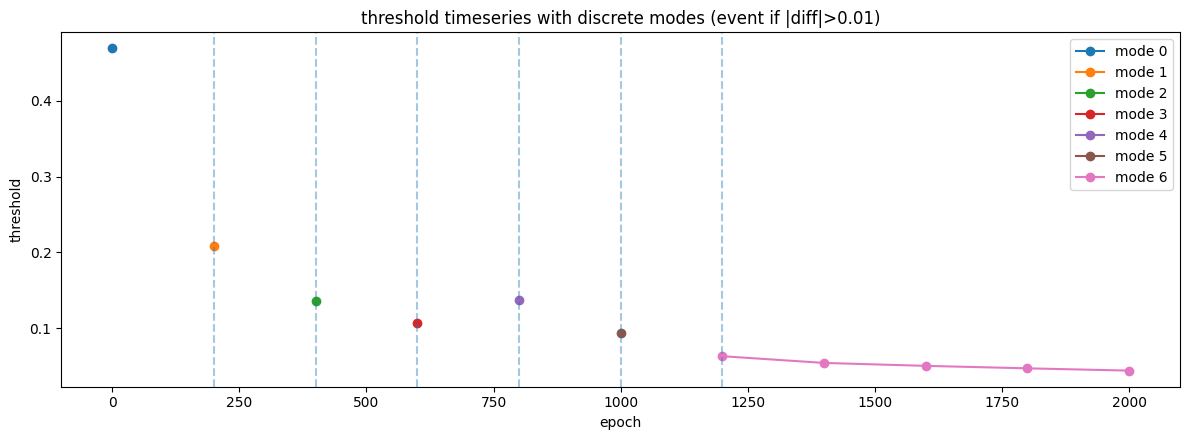

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========
# Config
# =========
EPS_EVENT = 0.01  # |threshold_diff| > EPS_EVENT をイベントとみなす（これまでの基準に合わせる）
IN_TIMESERIES = "/content/threshold_timeseries_with_events.csv"   # あれば優先
IN_EVENTS = "/content/threshold_update_events.csv"                # なければこちらから復元を試みる
OUT_DIR = "stepE_modes"
os.makedirs(OUT_DIR, exist_ok=True)

def build_timeseries_from_events(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    threshold_update_events.csv だけから threshold の時系列を（可能な範囲で）復元する。
    ※ epoch=0 の threshold が events_df に無い場合、threshold_prev から推定する。
    """
    ev = events_df.sort_values("epoch").reset_index(drop=True).copy()

    # epoch=0が無い前提で、最初の行の threshold_prev を epoch=0のthreshold とみなす
    # （あなたの貼り付けでは epoch=200 の threshold_prev が epoch=0 の threshold になっている）
    first_prev = float(ev.loc[0, "threshold_prev"])
    first_epoch = int(ev.loc[0, "epoch"])
    # 0->first_epoch までの点は、観測が無いので epoch=0 と event_epoch だけ持つ最小復元にする
    rows = []
    rows.append({"epoch": 0, "threshold": first_prev})
    for _, r in ev.iterrows():
        rows.append({"epoch": int(r["epoch"]), "threshold": float(r["threshold"])})
    ts = pd.DataFrame(rows).drop_duplicates("epoch").sort_values("epoch").reset_index(drop=True)

    # diffなどを計算
    ts["threshold_prev"] = ts["threshold"].shift(1)
    ts["threshold_diff"] = ts["threshold"] - ts["threshold_prev"]
    ts["abs_threshold_diff"] = ts["threshold_diff"].abs()
    ts["is_event"] = ts["abs_threshold_diff"] > EPS_EVENT
    ts["event_sign"] = np.sign(ts["threshold_diff"]).fillna(0).astype(int)
    return ts

def discretize_modes_by_events(ts: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    is_event（またはEPS基準）で区切って mode を付与する。
    mode_id: 0,1,2,...（イベントが起きるたびに+1）
    """
    df = ts.sort_values("epoch").reset_index(drop=True).copy()

    # is_event が無い場合は diffから作る
    if "threshold_diff" not in df.columns:
        df["threshold_prev"] = df["threshold"].shift(1)
        df["threshold_diff"] = df["threshold"] - df["threshold_prev"]
    if "abs_threshold_diff" not in df.columns:
        df["abs_threshold_diff"] = df["threshold_diff"].abs()
    if "is_event" not in df.columns:
        df["is_event"] = df["abs_threshold_diff"] > EPS_EVENT

    # mode付与（イベント行で mode が切り替わる）
    mode_id = []
    cur = 0
    for i, is_ev in enumerate(df["is_event"].fillna(False).tolist()):
        # i=0は前が無いのでイベント扱いしない
        if i != 0 and bool(is_ev):
            cur += 1
        mode_id.append(cur)
    df["mode_id"] = mode_id

    # mode区間サマリ
    seg = (df.groupby("mode_id")
             .agg(epoch_start=("epoch", "min"),
                  epoch_end=("epoch", "max"),
                  n_points=("epoch", "count"),
                  threshold_level=("threshold", "median"),
                  threshold_min=("threshold", "min"),
                  threshold_max=("threshold", "max"))
             .reset_index())

    return df, seg

# =========
# Load
# =========
if os.path.exists(IN_TIMESERIES):
    ts = pd.read_csv(IN_TIMESERIES)
    # 想定カラム名に寄せる（念のため）
    if "threshold" not in ts.columns and "threshold_value" in ts.columns:
        ts = ts.rename(columns={"threshold_value": "threshold"})
else:
    if not os.path.exists(IN_EVENTS):
        raise FileNotFoundError(f"Neither {IN_TIMESERIES} nor {IN_EVENTS} found.")
    events = pd.read_csv(IN_EVENTS)
    ts = build_timeseries_from_events(events)

# threshold列が無い場合は落とす
if "threshold" not in ts.columns:
    raise ValueError("timeseries CSV must contain 'threshold' column.")

# =========
# Discretize
# =========
ts_mode, mode_segments = discretize_modes_by_events(ts)

# =========
# Save CSV
# =========
out_ts = os.path.join(OUT_DIR, "stepE_threshold_modes.csv")
out_seg = os.path.join(OUT_DIR, "stepE_threshold_mode_segments.csv")
ts_mode.to_csv(out_ts, index=False)
mode_segments.to_csv(out_seg, index=False)
print("[saved]", out_ts)
print("[saved]", out_seg)

# =========
# Plot
# =========
plt.figure(figsize=(12, 4.5))
for m, g in ts_mode.groupby("mode_id"):
    plt.plot(g["epoch"], g["threshold"], marker="o", label=f"mode {m}")

# イベント箇所に縦線（あるなら）
ev_epochs = ts_mode.loc[ts_mode["is_event"].fillna(False), "epoch"].tolist()
for e in ev_epochs:
    plt.axvline(e, linestyle="--", alpha=0.4)

plt.title(f"threshold timeseries with discrete modes (event if |diff|>{EPS_EVENT})")
plt.xlabel("epoch")
plt.ylabel("threshold")
plt.legend()
plt.tight_layout()

out_png = os.path.join(OUT_DIR, "stepE_threshold_modes.png")
plt.savefig(out_png, dpi=150)
print("[saved]", out_png)

# =========
# Quick view
# =========
print("\n[mode segments]")
print(mode_segments)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === inputs ===
ENV_PATH = "/content/island_env_error.csv"
PROF_PATH = "/content/island_profile.csv"
EVENTS_PATH = "/content/threshold_update_events.csv"
THR_TS_PATH = "/content/threshold_timeseries_with_events.csv"  # あれば使う

OUTDIR = "/content/stepE_event_prepost"
os.makedirs(OUTDIR, exist_ok=True)

# === load ===
env = pd.read_csv(ENV_PATH)
prof = pd.read_csv(PROF_PATH)
events = pd.read_csv(EVENTS_PATH)

def pivot_wide(df, value_cols, prefix=""):
    """epoch×island -> epoch行 + (feature_island0, feature_island1, feature_diff_0_minus_1)"""
    wide = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    wide.columns = [f"{prefix}{col}_island{isl}" for col, isl in wide.columns]
    wide = wide.reset_index()

    for col in value_cols:
        c0 = f"{prefix}{col}_island0"
        c1 = f"{prefix}{col}_island1"
        if c0 in wide.columns and c1 in wide.columns:
            wide[f"{prefix}{col}_diff_0_minus_1"] = wide[c0] - wide[c1]
    return wide

env_value_cols = [c for c in env.columns if c not in ["epoch", "island", "n"]]
prof_value_cols = [c for c in prof.columns if c not in ["epoch", "island", "n"]]

env_w = pivot_wide(env, env_value_cols, prefix="env__")
prof_w = pivot_wide(prof, prof_value_cols, prefix="prof__")

feat = env_w.merge(prof_w, on="epoch", how="inner")

# threshold 時系列があるなら結合（任意）
if os.path.exists(THR_TS_PATH):
    thr_ts = pd.read_csv(THR_TS_PATH)
    cols = [c for c in ["epoch", "threshold", "threshold_prev", "threshold_diff", "is_event"] if c in thr_ts.columns]
    feat = feat.merge(thr_ts[cols], on="epoch", how="left")

epoch_list = sorted(feat["epoch"].dropna().unique().tolist())

def prev_epoch(e):
    idx = np.searchsorted(epoch_list, e) - 1
    return epoch_list[idx] if idx >= 0 else None

# numeric columns excluding epoch / bool
num_cols = []
for c in feat.columns:
    if c == "epoch":
        continue
    if pd.api.types.is_bool_dtype(feat[c]):
        continue
    if pd.api.types.is_numeric_dtype(feat[c]):
        num_cols.append(c)

# feature-wise std for z-score
std = feat[num_cols].std(numeric_only=True).replace(0, np.nan)

diff_rows = []
for _, ev in events.iterrows():
    e = int(ev["epoch"])
    pre = prev_epoch(e)
    if pre is None:
        continue

    pre_row = feat.loc[feat["epoch"] == pre, num_cols].iloc[0]
    post_row = feat.loc[feat["epoch"] == e, num_cols].iloc[0]

    diff = post_row - pre_row
    z = diff / std

    tmp = pd.DataFrame({
        "event_epoch": e,
        "pre_epoch": pre,
        "feature": diff.index,
        "pre": pre_row.values,
        "post": post_row.values,
        "diff": diff.values,
        "zscore": z.values
    })
    diff_rows.append(tmp)

diff_long = pd.concat(diff_rows, ignore_index=True)
diff_long["abs_z"] = diff_long["zscore"].abs()

# save long
diff_long.to_csv(f"{OUTDIR}/event_prepost_diff_long.csv", index=False)

# top-k per event
topk = 10
tops = []
for e in sorted(diff_long["event_epoch"].unique()):
    sub = diff_long[diff_long["event_epoch"] == e].sort_values("abs_z", ascending=False).head(topk).copy()
    sub["rank"] = np.arange(1, len(sub) + 1)
    tops.append(sub)
top_long = pd.concat(tops, ignore_index=True)
top_long.to_csv(f"{OUTDIR}/event_prepost_top10_by_absz.csv", index=False)

# per-event plot
for e in sorted(diff_long["event_epoch"].unique()):
    sub = diff_long[diff_long["event_epoch"] == e].sort_values("abs_z", ascending=False).head(12)
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(sub)), sub["zscore"].values)
    plt.xticks(range(len(sub)), sub["feature"].values, rotation=75, ha="right", fontsize=8)
    plt.axhline(0, linewidth=1)
    plt.title(f"Event @ epoch={e}: top changes (z-score) post-pre")
    plt.tight_layout()
    plt.savefig(f"{OUTDIR}/event_{e}_top_changes_zscore.png", dpi=160)
    plt.close()

# aggregate ranking across events
agg = (
    diff_long.groupby("feature")
    .agg(
        mean_abs_z=("abs_z", "mean"),
        mean_z=("zscore", "mean"),
        max_abs_z=("abs_z", "max"),
        n_events=("event_epoch", "nunique"),
    )
    .reset_index()
    .sort_values("mean_abs_z", ascending=False)
)
agg.to_csv(f"{OUTDIR}/event_prepost_feature_aggregate.csv", index=False)

print("Saved to:", OUTDIR)
print("\nTop features by mean |z| (across events):")
print(agg.head(20).to_string(index=False))


Saved to: /content/stepE_event_prepost

Top features by mean |z| (across events):
                                 feature  mean_abs_z    mean_z  max_abs_z  n_events
             env__err_signed_max_island0    1.481332 -0.386945   2.547687         6
                prof__y_sem_mean_island0    1.401290  0.207980   3.529927         6
             env__err_signed_p90_island0    1.389740  0.428230   2.958300         6
               prof__y_stat_mean_island0    1.349467  0.039905   3.928684         6
         env__err_abs_max_diff_0_minus_1    1.251848  0.306023   2.574751         6
     prof__delta_sun_mean_diff_0_minus_1    1.216631  0.342041   2.066854         6
         env__err_abs_p90_diff_0_minus_1    1.210084  0.298184   2.539583         6
            prof__delta_sun_mean_island0    1.168654  0.389683   2.214835         6
         env__err_abs_p75_diff_0_minus_1    1.133507  0.383141   2.251097         6
               prof__y_stat_mean_island1    1.127115 -0.085782   3.417731     

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, accuracy_score

# === load ===
feat = pd.read_csv("/content/event_prepost_diff_long.csv")  # 使わない
events = pd.read_csv("/content/threshold_update_events.csv")
state = pd.read_csv("/content/threshold_timeseries_with_events.csv")

env = pd.read_csv("/content/island_env_error.csv")
prof = pd.read_csv("/content/island_profile.csv")

# === build wide state ===
def pivot(df, value_cols, prefix):
    w = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    w.columns = [f"{prefix}{c}_island{isl}" for c, isl in w.columns]
    w = w.reset_index()
    for c in value_cols:
        c0 = f"{prefix}{c}_island0"
        c1 = f"{prefix}{c}_island1"
        if c0 in w and c1 in w:
            w[f"{prefix}{c}_diff"] = w[c0] - w[c1]
    return w

env_cols = [c for c in env.columns if c not in ["epoch", "island", "n"]]
prof_cols = [c for c in prof.columns if c not in ["epoch", "island", "n"]]

env_w = pivot(env, env_cols, "env__")
prof_w = pivot(prof, prof_cols, "prof__")

X = env_w.merge(prof_w, on="epoch")

# === label: event at next epoch ===
X["is_event_next"] = X["epoch"].shift(-1).isin(events["epoch"]).astype(int)

# drop last (no next)
X = X.iloc[:-1]

# === features / target ===
y = X["is_event_next"].values
X_feat = X.drop(columns=["epoch", "is_event_next"])

# standardize
X_feat = (X_feat - X_feat.mean()) / (X_feat.std() + 1e-6)
X_feat = X_feat.fillna(0.0)

# === LOO logistic regression ===
loo = LeaveOneOut()
probs = []
preds = []
ys = []

for train, test in loo.split(X_feat):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_feat.iloc[train], y[train])
    p = clf.predict_proba(X_feat.iloc[test])[:, 1][0]
    probs.append(p)
    preds.append(int(p > 0.5))
    ys.append(y[test][0])

print("LOO Accuracy:", accuracy_score(ys, preds))
print("LOO ROC-AUC :", roc_auc_score(ys, probs))


FileNotFoundError: [Errno 2] No such file or directory: '/content/event_prepost_diff_long.csv'

In [ ]:
# 最後に学習したモデルの重みを確認する（どの変数が重要か）
importance = pd.DataFrame({
    "feature": X_feat.columns,
    "coef": clf.coef_[0]
}).sort_values(by="coef", ascending=False)

print(importance.head(10)) # 正の影響が強い変数

NameError: name 'X_feat' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# =========================
# 0) Load
# =========================
thr = pd.read_csv("/content/threshold_timeseries_with_events.csv")
env = pd.read_csv("/content/island_env_error.csv")
prof = pd.read_csv("/content/island_profile.csv")

# 必要列チェック（足りなければCSV生成側と揃えてね）
assert "epoch" in thr.columns
assert "is_event" in thr.columns  # True/False or 0/1
if thr["is_event"].dtype != np.int64 and thr["is_event"].dtype != np.float64:
    # True/False -> 0/1
    thr["is_event"] = thr["is_event"].astype(int)

# =========================
# 1) epoch×island → epoch単位に wide 化（island0/island1 + 差分）
# =========================
def make_wide(df, value_cols, prefix):
    wide = df.pivot_table(index="epoch", columns="island", values=value_cols, aggfunc="mean")
    wide.columns = [f"{prefix}{col}_island{isl}" for col, isl in wide.columns]
    wide = wide.reset_index()

    # 差分(0-1)も作る（「島間の非対称」が効くことが多いので）
    for col in value_cols:
        c0 = f"{prefix}{col}_island0"
        c1 = f"{prefix}{col}_island1"
        if c0 in wide.columns and c1 in wide.columns:
            wide[f"{prefix}{col}_diff_0_minus_1"] = wide[c0] - wide[c1]
    return wide

env_cols = [c for c in env.columns if c not in ["epoch","island","n"]]
prof_cols = [c for c in prof.columns if c not in ["epoch","island","n"]]

env_w  = make_wide(env,  env_cols,  prefix="env__")
prof_w = make_wide(prof, prof_cols, prefix="prof__")

feat = env_w.merge(prof_w, on="epoch", how="inner")

# =========================
# 2) 「イベント直前の状態」だけで予測するデータセットを作る
#    y(t)=is_event(t) を、X(t-)=features(epoch_prev) で当てる
# =========================
epochs = sorted(feat["epoch"].unique().tolist())
epoch_to_prev = {epochs[i]: (epochs[i-1] if i > 0 else None) for i in range(len(epochs))}

rows = []
for _, r in thr.iterrows():
    e = int(r["epoch"])
    if e not in epoch_to_prev:
        continue
    pre = epoch_to_prev[e]
    if pre is None:
        continue  # epoch=0 は直前がないので除外
    # Xは "pre epoch" の特徴
    pre_row = feat.loc[feat["epoch"] == pre]
    if len(pre_row) != 1:
        continue
    x = pre_row.drop(columns=["epoch"]).iloc[0].to_dict()
    rows.append({
        "event_epoch": e,
        "pre_epoch": pre,
        "y_event": int(r["is_event"]),
        **{f"Xprev__{k}": v for k, v in x.items()}
    })

ds = pd.DataFrame(rows)

# 学習に使う特徴量
X_cols = [c for c in ds.columns if c.startswith("Xprev__")]
X = ds[X_cols].copy()
y = ds["y_event"].values

# 欠損のある列は落とす（または補完しても良い）
ok_cols = [c for c in X_cols if X[c].isna().sum() == 0]
X = X[ok_cols]

print("dataset:", ds.shape, "X:", X.shape, "y_event rate:", y.mean())

# =========================
# 3) LOOで評価（L1ロジスティック：解釈向き）
# =========================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=1.0,
        max_iter=10000,
        class_weight="balanced",
        random_state=0,
    ))
])

loo = LeaveOneOut()
proba = np.zeros(len(ds))
pred  = np.zeros(len(ds), dtype=int)

# 係数の安定性を見るため、各foldの係数も保存
coef_list = []

for tr_idx, te_idx in loo.split(X):
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr = y[tr_idx]
    pipe.fit(Xtr, ytr)
    proba[te_idx[0]] = pipe.predict_proba(Xte)[0,1]
    pred[te_idx[0]] = int(proba[te_idx[0]] >= 0.5)

    # fold係数
    clf = pipe.named_steps["clf"]
    coef_list.append(clf.coef_[0])

acc = accuracy_score(y, pred)

# ROC-AUCは「両クラスが存在する」ことが必要
auc = roc_auc_score(y, proba) if len(np.unique(y)) == 2 else np.nan

print("LOO Accuracy:", acc)
print("LOO ROC-AUC :", auc)

# 予測結果保存
out_pred = ds[["event_epoch","pre_epoch","y_event"]].copy()
out_pred["p_event"] = proba
out_pred["y_pred"]  = pred
out_pred.to_csv("stepA_event_linear_loo_preds.csv", index=False)

# =========================
# 4) “効いてる軸”を係数で出す
#    - 全データでfitした係数
#    - LOO係数の平均＆分散（安定性）
# =========================
pipe.fit(X, y)
coef_full = pipe.named_steps["clf"].coef_[0]

coef_arr = np.vstack(coef_list)
coef_mean = coef_arr.mean(axis=0)
coef_std  = coef_arr.std(axis=0)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef_full": coef_full,
    "coef_loo_mean": coef_mean,
    "coef_loo_std": coef_std,
    "abs_coef_loo_mean": np.abs(coef_mean),
})
coef_df = coef_df.sort_values("abs_coef_loo_mean", ascending=False)
coef_df.to_csv("stepA_event_linear_coeffs.csv", index=False)

print("\nTop axes (by |coef_loo_mean|):")
print(coef_df.head(20)[["feature","coef_loo_mean","coef_loo_std"]])

# =========================
# 5) 可視化（上位だけ）
# =========================
topk = min(20, len(coef_df))
sub = coef_df.head(topk).iloc[::-1]  # 反転して見やすく

plt.figure(figsize=(10, 6))
plt.barh(range(len(sub)), sub["coef_loo_mean"].values)
plt.yticks(range(len(sub)), sub["feature"].values, fontsize=8)
plt.axvline(0, linewidth=1)
plt.title("Event (mode transition) predictors: LOO-mean coefficients (LogReg L1)")
plt.tight_layout()
plt.savefig("stepA_event_linear_coeffs.png", dpi=160)
plt.close()

print("\nSaved:",
      "stepA_event_linear_loo_preds.csv, stepA_event_linear_coeffs.csv, stepA_event_linear_coeffs.png")


dataset: (10, 192) X: (10, 189) y_event rate: 0.6
LOO Accuracy: 0.8
LOO ROC-AUC : 0.9583333333333334

Top axes (by |coef_loo_mean|):
                                     feature  coef_loo_mean  coef_loo_std
179  Xprev__prof__attn_mean_0_diff_0_minus_1      -0.804540      0.252375
143         Xprev__prof__attn_mean_1_island0       0.720365      0.432913
151         Xprev__prof__attn_mean_5_island0      -0.299842      0.401536
142         Xprev__prof__attn_mean_0_island1       0.105640      0.316919
18        Xprev__env__err_signed_max_island0       0.078742      0.236225
145         Xprev__prof__attn_mean_2_island0       0.029539      0.088618
34        Xprev__env__err_signed_std_island0       0.019145      0.057434
180  Xprev__prof__attn_mean_1_diff_0_minus_1       0.014717      0.044150
181  Xprev__prof__attn_mean_2_diff_0_minus_1       0.006077      0.018230
5            Xprev__env__err_abs_min_island1       0.000000      0.000000
1            Xprev__env__err_abs_max_island1       0.

In [ ]:
!python stepF_sign_event_linear.py

Saved outputs to: stepF_sign_event_linear
Binary event model: see stepF_event_binary_metrics.txt / coeffs.csv / png
Sign model (events only): see stepF_event_sign_metrics.txt / coeffs.csv / png (if trained)


In [ ]:
!python stepG_feature_stability.py

[done] outputs saved to: stepG_outputs


# 状態系列クラスタの確認

In [ ]:
# stepH_state_trajectory_cluster.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

WINDOW = 2  # 前後 epoch
N_CLUSTERS = 3

# load
thr = pd.read_csv("threshold_timeseries_with_events.csv")
env = pd.read_csv("island_env_error.csv")
prof = pd.read_csv("island_profile.csv")

# merge minimal state
df = (
    thr.merge(env, on=["epoch", "island"])
       .merge(prof, on=["epoch", "island"])
)

# pick island-aggregated features
def state_vector(epoch):
    row0 = df[(df.epoch == epoch) & (df.island == 0)].iloc[0]
    row1 = df[(df.epoch == epoch) & (df.island == 1)].iloc[0]
    return np.array([
        row0["threshold"],
        row0["err_abs_mean"], row1["err_abs_mean"],
        row0["attn_mass_6"], row1["attn_mass_6"],
    ])

# extract event-centered trajectories
events = thr[thr["is_event"] == True]["epoch"].unique()
trajectories = []

for t in events:
    seq = []
    for dt in range(-WINDOW, WINDOW + 1):
        ep = t + dt
        if ep in thr["epoch"].values:
            seq.append(state_vector(ep))
    if len(seq) == 2 * WINDOW + 1:
        trajectories.append(np.concatenate(seq))

X = np.vstack(trajectories)
X = StandardScaler().fit_transform(X)


KeyError: 'island'

In [ ]:
# clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=0)
labels = kmeans.fit_predict(X)

print("silhouette:", silhouette_score(X, labels))

# visualize
from sklearn.decomposition import PCA
Z = PCA(2).fit_transform(X)

plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10")
plt.title("State-trajectory clusters")
plt.show()


NameError: name 'X' is not defined

# ε-event embedding

In [ ]:
!python step2_epsilon_event_embedding.py

[ok] saved to: step2_epsilon_event_embedding
[ok] events: 6 | emb_dim=6
[ok] files:
 - epsilon_event_embeddings.csv
 - epsilon_event_features_pre_only.csv
 - epsilon_event_features_pre_plus_delta.csv
 - epsilon_event_embedding_meta.json


In [ ]:
!python step_state_series_cluster_B.py --window 5 --stride 1 --k 3

[ok] saved to: stepB_state_series_clustering
  epochs in state table: 11
  trajectories: 6  dim: 1005
  chosen k: 3


In [ ]:
!python stepH_semantic_cluster_alignment.py

Traceback (most recent call last):
  File "/content/stepH_semantic_cluster_alignment.py", line 195, in <module>
    main()
  File "/content/stepH_semantic_cluster_alignment.py", line 89, in main
    traj, assign, X = load_run(r)
                      ^^^^^^^^^^^
  File "/content/stepH_semantic_cluster_alignment.py", line 43, in load_run
    traj = pd.read_csv(path_for(run, "traj"))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                

In [ ]:
!python step_label_lr_proposal.py

Traceback (most recent call last):
  File "/content/step_label_lr_proposal.py", line 90, in <module>
    main()
  File "/content/step_label_lr_proposal.py", line 35, in main
    aligned = pd.read_csv(ALIGNED_PATH)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1880, in _make_engine
    self.handles = get_handle(
   

In [ ]:
!python stepLR_cluster_eventrate.py --run_dir runs_for_analysis/run1 --mode conservative

# 学習からファイル出しまでの一括化

In [1]:
!RUN_ID=test1 python train.py

device: cuda
[RUN] RUN_ID=test1
[RUN] RUN_DIR=runs/test1
[LR] table not found: runs/test1/lr_mult_by_epoch.csv (disable)
[LR] disabled (no valid lr table)
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/test1/islands/island_epoch00000.pt
[0] L_real_mix=0.2048 L_real_sem=100.6313 L_cf_s0=0.6337 L_cf_p0=0.6364 L_mono=0.0000 L_cos=0.0559 H_I=0.8286 L_env=0.0000 L_self=0.1115 L_rev=0.6706 mse_s=0.3648 mse_p=0.2940 mse=0.3294 rev_abs_mean=0.0811 rev_std=0.0724 self_mass=0.1415 Val_sem=92.1372
   [MON-TR] y_mean=0.7802 y_std=0.0040 y_min=0.7705 y_max=0.7873 corr=0.7122 m_real=0.7802 m_s0=0.7749 m_p0=0.7762 gap_s=0.0052 gap_p=0.0039 ratio_s=0.9933 ratio_p=0.9950 env_sum=0.4349 I_sum=0.4235 self=0.1416 H_I=0.8291
   [MON-VA] y_mean=0.7802 y_std=0.0039 y_min=0.7706 y_max=0.7870 corr=0.7050 m_real=0.7802 m_s0=0.7751 m_p0=0.7761 gap_s=0.0051 gap_p=0.0041 ratio_s=0.9935 ratio_p=0.9948 env_sum=0.4349 I_sum=0.4235 self=0.1416 H_I=0.8291
[LR] epoch=200 mult=1.0000 lr=0.001
   [ISLA

In [2]:
!RUN_ID=test1 python stepLR_cluster_eventrate.py --min_points 3

[saved]
 - runs/test1/lr_mult_by_cluster.csv
 - runs/test1/lr_mult_by_epoch.csv

[preview lr_mult_by_cluster]
 cluster_label  n_points  n_events  event_rate  lr_mult  guarded
             1         1         1        1.00    1.000     True
             2         1         1        1.00    1.000     True
             0         8         2        0.25    1.025    False


In [3]:
!RUN_ID=test1 python train.py

device: cuda
[RUN] RUN_ID=test1
[RUN] RUN_DIR=runs/test1
[LR] using lr schedule table: runs/test1/lr_mult_by_epoch.csv
[LR] table preview (head):
epoch
0      1.000
200    1.025
400    1.000
600    1.025
800    1.000
[LR] table preview (tail):
epoch
1200    1.025
1400    1.025
1600    1.025
1800    1.025
2000    1.025
[LR] epoch=0 mult=1.0000 lr=0.001
   [ISLAND] saved snapshot: runs/test1/islands/island_epoch00000.pt
[0] L_real_mix=0.1867 L_real_sem=95.0556 L_cf_s0=0.5381 L_cf_p0=0.5312 L_mono=0.0000 L_cos=0.1362 H_I=0.8309 L_env=0.0000 L_self=0.1124 L_rev=0.7735 mse_s=0.2629 mse_p=0.1901 mse=0.2265 rev_abs_mean=0.0795 rev_std=0.0506 self_mass=0.1424 Val_sem=93.4916
   [MON-TR] y_mean=0.7148 y_std=0.0063 y_min=0.6980 y_max=0.7270 corr=0.8696 m_real=0.7148 m_s0=0.7107 m_p0=0.7071 gap_s=0.0041 gap_p=0.0077 ratio_s=0.9942 ratio_p=0.9892 env_sum=0.4333 I_sum=0.4246 self=0.1420 H_I=0.8302
   [MON-VA] y_mean=0.7150 y_std=0.0063 y_min=0.6987 y_max=0.7267 corr=0.8623 m_real=0.7150 m_s0=0.7108